# 🔍 Fake News Image Detection System

**Comprehensive Deep Learning System for Fake News Image Classification**

## 📋 System Components:
- **4 Vision Models**: ResNet50, ViT, EfficientNet-B4, Custom CNN
- **3 Fusion Strategies**: Early, Late, Attention-based
- **Two-Stage Training**: Warmup + Fine-tuning
- **Comprehensive Evaluation**: Multiple metrics and visualizations

---

## Step 1: GPU Setup and Verification

In [ ]:
import torch
import sys

print("="*80)
print("GPU CONFIGURATION")
print("="*80)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    device = torch.device('cuda')
    print("\n GPU is ready for training!")
else:
    device = torch.device('cpu')
    print("\n  WARNING: GPU not available. Training will be slow on CPU.")
    print("Please enable GPU: Runtime → Change runtime type → GPU")

print("="*80)

GPU CONFIGURATION
PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA version: 12.6
GPU Device: Tesla T4
GPU Memory: 15.83 GB

✅ GPU is ready for training!


## Step 2: Imported Dataset

```
dataset/
├── train/
│   ├── fake/
│   └── real/
├── valid/
│   ├── fake/
│   └── real/
└── test/
    ├── fake/
    └── real/
```

In [ ]:
# Here we have imported the dataset from Kaggle which was saved in our profile
import kagglehub
abdullahjaved384_images_dataset_path = kagglehub.dataset_download('abdullahjaved384/images-dataset')

print('Data source import complete.')

100%|██████████| 135M/135M [00:06<00:00, 20.5MB/s]

Extracting files...


Data source import complete.


## Step 3: Install Dependencies

In [ ]:
# # Install required packages
# !pip install timm h5py


## Step 4: Configuration

Central configuration for all hyperparameters and settings.

In [ ]:
"""
Configuration file for Fake News Image Detection System
Contains all hyperparameters, paths, and settings
"""

import torch
import random
import numpy as np

# ============================================================================
# REPRODUCIBILITY SETTINGS
# ============================================================================
RANDOM_SEED = 42

def set_seed(seed=RANDOM_SEED):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ============================================================================
# DEVICE CONFIGURATION
# ============================================================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_WORKERS = 4  # For DataLoader

# ============================================================================
# DATASET PATHS
# ============================================================================
DATASET_ROOT = '/kaggle/input/images-dataset'
TRAIN_DIR = f'{DATASET_ROOT}/train'
VALID_DIR = f'{DATASET_ROOT}/valid'
TEST_DIR = f'{DATASET_ROOT}/test'

# Class names
CLASS_NAMES = ['real', 'fake']
NUM_CLASSES = 2

# ============================================================================
# IMAGE PREPROCESSING
# ============================================================================
# ImageNet normalization statistics
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Image dimensions
IMG_SIZE = 224
IMG_CHANNELS = 3

# ============================================================================
# DATA AUGMENTATION PARAMETERS
# ============================================================================
# Rotation
ROTATION_DEGREES = 15

# Scaling
SCALE_MIN = 0.8
SCALE_MAX = 1.2

# Color jitter
BRIGHTNESS = 0.2
CONTRAST = 0.2
SATURATION = 0.2
HUE = 0.1

# Gaussian blur
BLUR_PROBABILITY = 0.1
BLUR_KERNEL_SIZE = 5

# Noise injection
NOISE_PROBABILITY = 0.1
NOISE_STD = 0.01

# ============================================================================
# TRAINING HYPERPARAMETERS
# ============================================================================
# Batch size
BATCH_SIZE = 32

# Learning rates
LR_PRETRAINED = 1e-5  # For pretrained models (ResNet, ViT, EfficientNet)
LR_CUSTOM = 1e-4      # For custom CNN and fusion layers
LR_WARMUP = 1e-3      # For custom CNN initial training

# Optimizer parameters (Adam)
BETA1 = 0.9
BETA2 = 0.999
WEIGHT_DECAY = 1e-5

# Learning rate scheduler
LR_STEP_SIZE = 15  # Reduce LR every N epochs
LR_GAMMA = 0.1     # Multiply LR by this factor

# Training epochs
WARMUP_EPOCHS = 10    # Stage 1: frozen pretrained models
FINETUNE_EPOCHS = 40  # Stage 2: end-to-end fine-tuning
MAX_EPOCHS = WARMUP_EPOCHS + FINETUNE_EPOCHS

# Early stopping
EARLY_STOP_PATIENCE = 7  # Stop if no improvement for N epochs

# ============================================================================
# MODEL ARCHITECTURE PARAMETERS
# ============================================================================
# Embedding dimensions
RESNET50_EMB_DIM = 2048
VIT_EMB_DIM = 768
EFFICIENTNET_EMB_DIM = 1792
CUSTOM_CNN_EMB_DIM = 1024

# Total concatenated embedding dimension
TOTAL_EMB_DIM = RESNET50_EMB_DIM + VIT_EMB_DIM + EFFICIENTNET_EMB_DIM + CUSTOM_CNN_EMB_DIM

# Dropout rates (decreasing in deeper layers)
DROPOUT_RATE_1 = 0.3
DROPOUT_RATE_2 = 0.2
DROPOUT_RATE_3 = 0.1

# Custom CNN parameters
CUSTOM_CNN_KERNELS = [3, 5, 7]  # Multi-scale kernel sizes

# ============================================================================
# FUSION STRATEGY PARAMETERS
# ============================================================================
# Early fusion network dimensions
EARLY_FUSION_DIMS = [TOTAL_EMB_DIM, 2048, 512, 128, 1]

# Late fusion - number of models
NUM_MODELS = 4

# Attention fusion dimensions
ATTENTION_HIDDEN_DIM = 256
ATTENTION_COMMON_DIM = 512

# ============================================================================
# TRAINING CONFIGURATION
# ============================================================================
# Which models to train
TRAIN_RESNET50 = True
TRAIN_VIT = True
TRAIN_EFFICIENTNET = True
TRAIN_CUSTOM_CNN = True

# Which fusion strategies to train
TRAIN_EARLY_FUSION = True
TRAIN_LATE_FUSION = True
TRAIN_ATTENTION_FUSION = True

# ============================================================================
# CHECKPOINT AND LOGGING
# ============================================================================
CHECKPOINT_DIR = 'checkpoints'
LOG_DIR = 'logs'
RESULTS_DIR = 'results'
EMBEDDINGS_CACHE_DIR = 'embeddings_cache'

# Save checkpoints
SAVE_BEST_ONLY = True  # Only save when validation metric improves
SAVE_METRIC = 'f1'     # Metric to monitor: 'f1', 'accuracy', 'auc'

# Logging frequency
LOG_INTERVAL = 10  # Log every N batches

# ============================================================================
# EVALUATION METRICS
# ============================================================================
METRICS = ['accuracy', 'precision', 'recall', 'f1', 'auc_roc']

# Confusion matrix
PLOT_CONFUSION_MATRIX = True

# Embedding visualization
VISUALIZE_EMBEDDINGS = True
TSNE_PERPLEXITY = 30
UMAP_N_NEIGHBORS = 15

# ============================================================================
# MODEL-SPECIFIC SETTINGS
# ============================================================================
# ResNet50
RESNET50_PRETRAINED = True
RESNET50_FREEZE_UNTIL_EPOCH = 5  # Freeze BatchNorm until this epoch

# Vision Transformer (ViT)
VIT_MODEL_NAME = 'vit_base_patch16_224'  # timm model name
VIT_PRETRAINED = True
VIT_FREEZE_PATCH_EMBED = True  # Keep patch embedding frozen
VIT_FINETUNE_LAST_N_BLOCKS = 4  # Only fine-tune last N transformer blocks

# EfficientNet-B4
EFFICIENTNET_MODEL_NAME = 'efficientnet_b4'  # timm model name
EFFICIENTNET_PRETRAINED = True
EFFICIENTNET_PROGRESSIVE_UNFREEZE = True  # Unfreeze layers progressively

# Custom CNN
CUSTOM_CNN_INIT = 'kaiming'  # Weight initialization: 'kaiming' or 'xavier'

# ============================================================================
# INFERENCE SETTINGS
# ============================================================================
INFERENCE_BATCH_SIZE = 64
CONFIDENCE_THRESHOLD = 0.5  # Threshold for binary classification

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================
def get_model_save_path(model_name, fusion_type=None):
    """Get checkpoint save path for a model"""
    if fusion_type:
        return f'{CHECKPOINT_DIR}/{model_name}_{fusion_type}_best.pth'
    return f'{CHECKPOINT_DIR}/{model_name}_best.pth'

def get_embedding_cache_path(model_name, split='train'):
    """Get path for cached embeddings"""
    return f'{EMBEDDINGS_CACHE_DIR}/{model_name}_{split}_embeddings.h5'

# ============================================================================
# DISPLAY CONFIGURATION
# ============================================================================
def print_config():
    """Print current configuration"""
    print("=" * 80)
    print("FAKE NEWS IMAGE DETECTION - CONFIGURATION")
    print("=" * 80)
    print(f"Device: {DEVICE}")
    print(f"Random Seed: {RANDOM_SEED}")
    print(f"Batch Size: {BATCH_SIZE}")
    print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
    print(f"Max Epochs: {MAX_EPOCHS} (Warmup: {WARMUP_EPOCHS}, Finetune: {FINETUNE_EPOCHS})")
    print(f"Learning Rates: Pretrained={LR_PRETRAINED}, Custom={LR_CUSTOM}")
    print(f"Early Stop Patience: {EARLY_STOP_PATIENCE}")
    print("-" * 80)
    print("Models to train:")
    print(f"  - ResNet50: {TRAIN_RESNET50}")
    print(f"  - ViT: {TRAIN_VIT}")
    print(f"  - EfficientNet-B4: {TRAIN_EFFICIENTNET}")
    print(f"  - Custom CNN: {TRAIN_CUSTOM_CNN}")
    print("-" * 80)
    print("Fusion strategies:")
    print(f"  - Early Fusion: {TRAIN_EARLY_FUSION}")
    print(f"  - Late Fusion: {TRAIN_LATE_FUSION}")
    print(f"  - Attention Fusion: {TRAIN_ATTENTION_FUSION}")
    print("=" * 80)

if __name__ == '__main__':
    print_config()


FAKE NEWS IMAGE DETECTION - CONFIGURATION
Device: cuda
Random Seed: 42
Batch Size: 32
Image Size: 224x224
Max Epochs: 50 (Warmup: 10, Finetune: 40)
Learning Rates: Pretrained=1e-05, Custom=0.0001
Early Stop Patience: 7
--------------------------------------------------------------------------------
Models to train:
  - ResNet50: True
  - ViT: True
  - EfficientNet-B4: True
  - Custom CNN: True
--------------------------------------------------------------------------------
Fusion strategies:
  - Early Fusion: True
  - Late Fusion: True
  - Attention Fusion: True


## Step 5: Data Loading and Preprocessing

- ImageNet normalization
- Data augmentation (rotation, flips, scaling, color jittering, blur, noise)
- Train/validation/test data loaders

In [ ]:
%%writefile config.py
"""
Configuration file for Fake News Image Detection System
Contains all hyperparameters, paths, and settings
"""

import torch
import random
import numpy as np

# ============================================================================
# REPRODUCIBILITY SETTINGS
# ============================================================================
RANDOM_SEED = 42

def set_seed(seed=RANDOM_SEED):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Note: Setting deterministic mode may reduce performance
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ============================================================================
# DEVICE CONFIGURATION
# ============================================================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_WORKERS = 4  # For DataLoader

# ============================================================================
# DATASET PATHS
# ============================================================================
DATASET_ROOT = '/root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1'
TRAIN_DIR = f'{DATASET_ROOT}/train'
VALID_DIR = f'{DATASET_ROOT}/valid'
TEST_DIR = f'{DATASET_ROOT}/test'

# Class names
CLASS_NAMES = ['real', 'fake']
NUM_CLASSES = 2

# ============================================================================
# IMAGE PREPROCESSING
# ============================================================================
# ImageNet normalization statistics
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Image dimensions
IMG_SIZE = 224
IMG_CHANNELS = 3

# ============================================================================
# DATA AUGMENTATION PARAMETERS
# ============================================================================
# Rotation
ROTATION_DEGREES = 15

# Scaling
SCALE_MIN = 0.8
SCALE_MAX = 1.2

# Color jitter
BRIGHTNESS = 0.2
CONTRAST = 0.2
SATURATION = 0.2
HUE = 0.1

# Gaussian blur
BLUR_PROBABILITY = 0.1
BLUR_KERNEL_SIZE = 5

# Noise injection
NOISE_PROBABILITY = 0.1
NOISE_STD = 0.01

# ============================================================================
# TRAINING HYPERPARAMETERS
# ============================================================================
# Batch size
BATCH_SIZE = 32

# Learning rates
LR_PRETRAINED = 1e-5  # For pretrained models (ResNet, ViT, EfficientNet)
LR_CUSTOM = 1e-4      # For custom CNN and fusion layers
LR_WARMUP = 1e-3      # For custom CNN initial training

# Optimizer parameters (Adam)
BETA1 = 0.9
BETA2 = 0.999
WEIGHT_DECAY = 1e-5

# Learning rate scheduler
LR_STEP_SIZE = 15  # Reduce LR every N epochs
LR_GAMMA = 0.1     # Multiply LR by this factor

# Training epochs
WARMUP_EPOCHS = 10    # Stage 1: frozen pretrained models
FINETUNE_EPOCHS = 40  # Stage 2: end-to-end fine-tuning
MAX_EPOCHS = WARMUP_EPOCHS + FINETUNE_EPOCHS

# Early stopping
EARLY_STOP_PATIENCE = 7  # Stop if no improvement for N epochs

# ============================================================================
# MODEL ARCHITECTURE PARAMETERS
# ============================================================================
# Embedding dimensions
RESNET50_EMB_DIM = 2048
VIT_EMB_DIM = 768
EFFICIENTNET_EMB_DIM = 1792
CUSTOM_CNN_EMB_DIM = 1024

# Total concatenated embedding dimension
TOTAL_EMB_DIM = RESNET50_EMB_DIM + VIT_EMB_DIM + EFFICIENTNET_EMB_DIM + CUSTOM_CNN_EMB_DIM

# Dropout rates (decreasing in deeper layers)
DROPOUT_RATE_1 = 0.3
DROPOUT_RATE_2 = 0.2
DROPOUT_RATE_3 = 0.1

# Custom CNN parameters
CUSTOM_CNN_KERNELS = [3, 5, 7]  # Multi-scale kernel sizes

# ============================================================================
# FUSION STRATEGY PARAMETERS
# ============================================================================
# Early fusion network dimensions
EARLY_FUSION_DIMS = [TOTAL_EMB_DIM, 2048, 512, 128, 1]

# Late fusion - number of models
NUM_MODELS = 4

# Attention fusion dimensions
ATTENTION_HIDDEN_DIM = 256
ATTENTION_COMMON_DIM = 512

# ============================================================================
# TRAINING CONFIGURATION
# ============================================================================
# Which models to train
TRAIN_RESNET50 = True
TRAIN_VIT = True
TRAIN_EFFICIENTNET = True
TRAIN_CUSTOM_CNN = True

# Which fusion strategies to train
TRAIN_EARLY_FUSION = True
TRAIN_LATE_FUSION = True
TRAIN_ATTENTION_FUSION = True

# ============================================================================
# CHECKPOINT AND LOGGING
# ============================================================================
CHECKPOINT_DIR = 'checkpoints'
LOG_DIR = 'logs'
RESULTS_DIR = 'results'
EMBEDDINGS_CACHE_DIR = 'embeddings_cache'

# Save checkpoints
SAVE_BEST_ONLY = True  # Only save when validation metric improves
SAVE_METRIC = 'f1'     # Metric to monitor: 'f1', 'accuracy', 'auc'

# Logging frequency
LOG_INTERVAL = 10  # Log every N batches

# ============================================================================
# EVALUATION METRICS
# ============================================================================
METRICS = ['accuracy', 'precision', 'recall', 'f1', 'auc_roc']

# Confusion matrix
PLOT_CONFUSION_MATRIX = True

# Embedding visualization
VISUALIZE_EMBEDDINGS = True
TSNE_PERPLEXITY = 30
UMAP_N_NEIGHBORS = 15

# ============================================================================
# MODEL-SPECIFIC SETTINGS
# ============================================================================
# ResNet50
RESNET50_PRETRAINED = True
RESNET50_FREEZE_UNTIL_EPOCH = 5  # Freeze BatchNorm until this epoch

# Vision Transformer (ViT)
VIT_MODEL_NAME = 'vit_base_patch16_224'  # timm model name
VIT_PRETRAINED = True
VIT_FREEZE_PATCH_EMBED = True  # Keep patch embedding frozen
VIT_FINETUNE_LAST_N_BLOCKS = 4  # Only fine-tune last N transformer blocks

# EfficientNet-B4
EFFICIENTNET_MODEL_NAME = 'efficientnet_b4'
EFFICIENTNET_PRETRAINED = True
EFFICIENTNET_PROGRESSIVE_UNFREEZE = True  # Unfreeze layers progressively

# Custom CNN
CUSTOM_CNN_INIT = 'kaiming'  # Weight initialization: 'kaiming' or 'xavier'

# ============================================================================
# INFERENCE SETTINGS
# ============================================================================
INFERENCE_BATCH_SIZE = 64
CONFIDENCE_THRESHOLD = 0.5  # Threshold for binary classification

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================
def get_model_save_path(model_name, fusion_type=None):
    """Get checkpoint save path for a model"""
    if fusion_type:
        return f'{CHECKPOINT_DIR}/{model_name}_{fusion_type}_best.pth'
    return f'{CHECKPOINT_DIR}/{model_name}_best.pth'

def get_embedding_cache_path(model_name, split='train'):
    """Get path for cached embeddings"""
    return f'{EMBEDDINGS_CACHE_DIR}/{model_name}_{split}_embeddings.h5'

# ============================================================================
# DISPLAY CONFIGURATION
# ============================================================================
def print_config():
    """Print current configuration"""
    print("=" * 80)
    print("FAKE NEWS IMAGE DETECTION - CONFIGURATION")
    print("=" * 80)
    print(f"Device: {DEVICE}")
    print(f"Random Seed: {RANDOM_SEED}")
    print(f"Batch Size: {BATCH_SIZE}")
    print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
    print(f"Max Epochs: {MAX_EPOCHS} (Warmup: {WARMUP_EPOCHS}, Finetune: {FINETUNE_EPOCHS})")
    print(f"Learning Rates: Pretrained={LR_PRETRAINED}, Custom={LR_CUSTOM}")
    print(f"Early Stop Patience: {EARLY_STOP_PATIENCE}")
    print("-" * 80)
    print("Models to train:")
    print(f"  - ResNet50: {TRAIN_RESNET50}")
    print(f"  - ViT: {TRAIN_VIT}")
    print(f"  - EfficientNet-B4: {TRAIN_EFFICIENTNET}")
    print(f"  - Custom CNN: {TRAIN_CUSTOM_CNN}")
    print("-" * 80)
    print("Fusion strategies:")
    print(f"  - Early Fusion: {TRAIN_EARLY_FUSION}")
    print(f"  - Late Fusion: {TRAIN_LATE_FUSION}")
    print(f"  - Attention Fusion: {TRAIN_ATTENTION_FUSION}")
    print("=" * 80)

if __name__ == '__main__':
    print_config()


Writing config.py


In [ ]:
"""
Data loading and preprocessing pipeline for Fake News Image Detection
Implements custom Dataset class with augmentation and normalization
"""

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from pathlib import Path
import config


class FakeNewsDataset(Dataset):

    def __init__(self, root_dir, transform=None, augment=False):
        """
        Args:
            root_dir (str): Root directory containing 'fake' and 'real' subdirectories
            transform (callable, optional): Optional transform to be applied on images
            augment (bool): Whether to apply data augmentation (for training)
        """
        self.root_dir = root_dir
        self.augment = augment

        # Collect all image paths and labels
        self.image_paths = []
        self.labels = []

        # Label mapping: real=0, fake=1
        self.class_to_idx = {'real': 0, 'fake': 1}
        self.idx_to_class = {0: 'real', 1: 'fake'}

        # Load images from both classes
        for class_name in ['real', 'fake']:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"Warning: Directory {class_dir} does not exist!")
                continue

            label = self.class_to_idx[class_name]

            # Get all image files
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_file)
                    self.image_paths.append(img_path)
                    self.labels.append(label)

        print(f"Loaded {len(self.image_paths)} images from {root_dir}")
        print(f"  - Real: {self.labels.count(0)}")
        print(f"  - Fake: {self.labels.count(1)}")

        # Set up transforms
        if transform is not None:
            self.transform = transform
        else:
            self.transform = self._get_default_transform()

    def _get_default_transform(self):
        """Get default transform pipeline based on augmentation setting"""

        if self.augment:
            # Training transforms with augmentation
            transform_list = [
                transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
                transforms.RandomRotation(degrees=config.ROTATION_DEGREES),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomResizedCrop(
                    config.IMG_SIZE,
                    scale=(config.SCALE_MIN, config.SCALE_MAX)
                ),
                transforms.ColorJitter(
                    brightness=config.BRIGHTNESS,
                    contrast=config.CONTRAST,
                    saturation=config.SATURATION,
                    hue=config.HUE
                ),
                transforms.RandomApply([
                    transforms.GaussianBlur(
                        kernel_size=config.BLUR_KERNEL_SIZE,
                        sigma=(0.1, 2.0)
                    )
                ], p=config.BLUR_PROBABILITY),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=config.IMAGENET_MEAN,
                    std=config.IMAGENET_STD
                ),
                AddGaussianNoise(std=config.NOISE_STD, p=config.NOISE_PROBABILITY)
            ]
        else:
            # Validation/Test transforms without augmentation
            transform_list = [
                transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=config.IMAGENET_MEAN,
                    std=config.IMAGENET_STD
                )
            ]

        return transforms.Compose(transform_list)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Returns:
            image (Tensor): Preprocessed image tensor [3, 224, 224]
            label (int): Class label (0=real, 1=fake)
        """
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a blank image if loading fails
            image = Image.new('RGB', (config.IMG_SIZE, config.IMG_SIZE), color='black')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

    def get_class_distribution(self):
        """Get distribution of classes in the dataset"""
        unique, counts = np.unique(self.labels, return_counts=True)
        distribution = dict(zip([self.idx_to_class[i] for i in unique], counts))
        return distribution


class AddGaussianNoise:
    """Add Gaussian noise to tensor"""

    def __init__(self, std=0.01, p=0.1):
        """
        Args:
            std (float): Standard deviation of noise
            p (float): Probability of applying noise
        """
        self.std = std
        self.p = p

    def __call__(self, tensor):
        if torch.rand(1).item() < self.p:
            noise = torch.randn_like(tensor) * self.std
            tensor = tensor + noise
            # Clamp to valid range
            tensor = torch.clamp(tensor, 0, 1)
        return tensor

    def __repr__(self):
        return f'{self.__class__.__name__}(std={self.std}, p={self.p})'


def get_data_loaders(batch_size=None, num_workers=None):

    if batch_size is None:
        batch_size = config.BATCH_SIZE
    if num_workers is None:
        num_workers = config.NUM_WORKERS

    # Create datasets
    train_dataset = FakeNewsDataset(
        root_dir=config.TRAIN_DIR,
        augment=True  # Aly augmentation for training
    )

    valid_dataset = FakeNewsDataset(
        root_dir=config.VALID_DIR,
        augment=False  # No augmentation for validation
    )

    test_dataset = FakeNewsDataset(
        root_dir=config.TEST_DIR,
        augment=False  # No augmentation for testing
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if config.DEVICE.type == 'cuda' else False
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if config.DEVICE.type == 'cuda' else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if config.DEVICE.type == 'cuda' else False
    )

    loaders = {
        'train': train_loader,
        'valid': valid_loader,
        'test': test_loader
    }

    # Print dataset statistics
    print("\n" + "=" * 80)
    print("DATASET STATISTICS")
    print("=" * 80)
    print(f"Training samples: {len(train_dataset)}")
    print(f"  Distribution: {train_dataset.get_class_distribution()}")
    print(f"Validation samples: {len(valid_dataset)}")
    print(f"  Distribution: {valid_dataset.get_class_distribution()}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"  Distribution: {test_dataset.get_class_distribution()}")
    print(f"\nBatch size: {batch_size}")
    print(f"Number of workers: {num_workers}")
    print("=" * 80 + "\n")

    return loaders


def test_data_loader():
    """Test function to verify data loading works correctly"""
    print("Testing data loader...")

    # Create a small test dataset
    train_dataset = FakeNewsDataset(
        root_dir=config.TRAIN_DIR,
        augment=True
    )

    # Test single item
    img, label = train_dataset[0]
    print(f"\nSingle item test:")
    print(f"  Image shape: {img.shape}")
    print(f"  Image dtype: {img.dtype}")
    print(f"  Image range: [{img.min():.3f}, {img.max():.3f}]")
    print(f"  Label: {label} ({train_dataset.idx_to_class[label]})")

    # Test data loader
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    images, labels = next(iter(train_loader))
    print(f"\nBatch test:")
    print(f"  Batch images shape: {images.shape}")
    print(f"  Batch labels shape: {labels.shape}")
    print(f"  Labels: {labels.tolist()}")

    print("\n✓ Data loader test passed!")


if __name__ == '__main__':
    # Set seed for reproducibility
    config.set_seed()

    # Test the data loader
    test_data_loader()

    # Create all data loaders
    print("\nCreating all data loaders...")
    loaders = get_data_loaders()

    print("\n✓ All data loaders created successfully!")


Testing data loader...
Loaded 1795 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/train
  - Real: 894
  - Fake: 901

Single item test:
  Image shape: torch.Size([3, 224, 224])
  Image dtype: torch.float32
  Image range: [0.000, 1.000]
  Label: 0 (real)

Batch test:
  Batch images shape: torch.Size([4, 3, 224, 224])
  Batch labels shape: torch.Size([4])
  Labels: [1, 1, 0, 0]

✓ Data loader test passed!

Creating all data loaders...
Loaded 1795 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/train
  - Real: 894
  - Fake: 901
Loaded 174 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/valid
  - Real: 89
  - Fake: 85
Loaded 81 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/test
  - Real: 40
  - Fake: 41

DATASET STATISTICS
Training samples: 1795
  Distribution: {'real': np.int64(894), 'fake': np.int64(901)}
Validation samples: 174
  D

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Test data loading
print("Testing data loading...")
set_seed()
loaders = get_data_loaders(batch_size=32)

# Get a sample batch
sample_batch = next(iter(loaders['train']))
images, labels = sample_batch

print(f"\n✅ Data loading successful!")
print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Image range: [{images.min():.3f}, {images.max():.3f}]")

Testing data loading...
Loaded 1795 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/train
  - Real: 894
  - Fake: 901
Loaded 174 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/valid
  - Real: 89
  - Fake: 85
Loaded 81 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/test
  - Real: 40
  - Fake: 41

DATASET STATISTICS
Training samples: 1795
  Distribution: {'real': np.int64(894), 'fake': np.int64(901)}
Validation samples: 174
  Distribution: {'real': np.int64(89), 'fake': np.int64(85)}
Test samples: 81
  Distribution: {'real': np.int64(40), 'fake': np.int64(41)}

Batch size: 32
Number of workers: 4


✅ Data loading successful!
Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Image range: [-2.118, 2.640]


## Step 6: Model Architectures

Implementing all four vision models with embedding extraction capabilities.

### 6.1 ResNet50 Model (2048-dim embeddings)

In [ ]:
"""
ResNet50 Model for Fake News Image Detection
Pretrained on ImageNet, extracts 2048-dimensional embeddings
"""

import torch
import torch.nn as nn
from torchvision import models
import sys
sys.path.append('..')
import config


class ResNet50Model(nn.Module):
    """
    ResNet50 feature extractor with classification head

    Architecture:
    - Pretrained ResNet50 backbone (frozen initially)
    - Global Average Pooling -> 2048-dim embedding
    - Classification head: 2048 -> 512 -> 1
    """

    def __init__(self, pretrained=True, freeze_backbone=True):
        """
        Args:
            pretrained (bool): Load ImageNet pretrained weights
            freeze_backbone (bool): Freeze backbone weights initially
        """
        super(ResNet50Model, self).__init__()

        # Load pretrained ResNet50
        self.backbone = models.resnet50(pretrained=pretrained)

        # Remove the final fully connected layer
        # ResNet50 has: ... -> avgpool -> fc
        # We want: ... -> avgpool (gives 2048-dim embedding)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])

        # Freeze backbone if specified
        if freeze_backbone:
            self.freeze_backbone()

        # Global Average Pooling (already included in backbone)
        # Output shape: [batch_size, 2048, 1, 1]

        # Flatten layer
        self.flatten = nn.Flatten()

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(config.RESNET50_EMB_DIM, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(config.DROPOUT_RATE_2),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

        # Initialize classifier weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize classifier weights using Kaiming initialization"""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def freeze_backbone(self):
        """Freeze all backbone parameters"""
        for param in self.backbone.parameters():
            param.requires_grad = False
        print("ResNet50 backbone frozen")

    def unfreeze_backbone(self):
        """Unfreeze all backbone parameters"""
        for param in self.backbone.parameters():
            param.requires_grad = True
        print("ResNet50 backbone unfrozen")

    def freeze_bn(self):
        """Freeze BatchNorm layers in backbone"""
        for module in self.backbone.modules():
            if isinstance(module, nn.BatchNorm2d):
                module.eval()
                for param in module.parameters():
                    param.requires_grad = False

    def forward(self, x, return_embedding=False):
        """
        Forward pass

        Args:
            x (Tensor): Input images [batch_size, 3, 224, 224]
            return_embedding (bool): If True, return both embedding and output

        Returns:
            If return_embedding=False:
                output (Tensor): Classification output [batch_size, 1]
            If return_embedding=True:
                (embedding, output): Tuple of embedding [batch_size, 2048] and output [batch_size, 1]
        """
        # Extract features through backbone
        features = self.backbone(x)  # [batch_size, 2048, 1, 1]

        # Flatten to get embedding
        embedding = self.flatten(features)  # [batch_size, 2048]

        # Classification
        output = self.classifier(embedding)  # [batch_size, 1]

        if return_embedding:
            return embedding, output
        else:
            return output

    def get_embedding(self, x):
        """
        Extract only the embedding without classification

        Args:
            x (Tensor): Input images [batch_size, 3, 224, 224]

        Returns:
            embedding (Tensor): Feature embedding [batch_size, 2048]
        """
        with torch.no_grad():
            features = self.backbone(x)
            embedding = self.flatten(features)
        return embedding


def test_resnet50():
    """Test ResNet50 model"""
    print("Testing ResNet50 Model...")
    print("=" * 80)

    # Create model
    model = ResNet50Model(pretrained=False, freeze_backbone=False)
    model.eval()

    # Create dummy input
    batch_size = 4
    dummy_input = torch.randn(batch_size, 3, config.IMG_SIZE, config.IMG_SIZE)

    print(f"Input shape: {dummy_input.shape}")

    # Test forward pass
    with torch.no_grad():
        output = model(dummy_input)
        print(f"Output shape: {output.shape}")
        print(f"Output range: [{output.min():.4f}, {output.max():.4f}]")

        # Test with embedding
        embedding, output2 = model(dummy_input, return_embedding=True)
        print(f"Embedding shape: {embedding.shape}")
        print(f"Embedding mean: {embedding.mean():.4f}, std: {embedding.std():.4f}")

        # Test get_embedding
        emb = model.get_embedding(dummy_input)
        print(f"Get embedding shape: {emb.shape}")

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Test freeze/unfreeze
    model.freeze_backbone()
    trainable_after_freeze = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable after freeze: {trainable_after_freeze:,}")

    model.unfreeze_backbone()
    trainable_after_unfreeze = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable after unfreeze: {trainable_after_unfreeze:,}")

    print("=" * 80)
    print("✓ ResNet50 model test passed!")


if __name__ == '__main__':
    test_resnet50()


Testing ResNet50 Model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Input shape: torch.Size([4, 3, 224, 224])
Output shape: torch.Size([4, 1])
Output range: [1.0000, 1.0000]
Embedding shape: torch.Size([4, 2048])
Embedding mean: 21.2915, std: 21.5964
Get embedding shape: torch.Size([4, 2048])

Total parameters: 24,558,657
Trainable parameters: 24,558,657
ResNet50 backbone frozen
Trainable after freeze: 1,050,625
ResNet50 backbone unfrozen
Trainable after unfreeze: 24,558,657
✓ ResNet50 model test passed!


### 6.2 Vision Transformer (768-dim embeddings)

In [ ]:
"""
Vision Transformer (ViT) Model for Fake News Image Detection
Pretrained ViT-B/16, extracts 768-dimensional embeddings
"""

import torch
import torch.nn as nn
import timm
import sys
sys.path.append('..')
import config


class ViTModel(nn.Module):
    """
    Vision Transformer (ViT-B/16) feature extractor with classification head

    Architecture:
    - Pretrained ViT-B/16 backbone (patch size 16x16)
    - Class token embedding -> 768-dim
    - Classification head: 768 -> 256 -> 1
    """

    def __init__(self, pretrained=True, freeze_backbone=True, freeze_patch_embed=True):
        """
        Args:
            pretrained (bool): Load ImageNet pretrained weights
            freeze_backbone (bool): Freeze backbone weights initially
            freeze_patch_embed (bool): Keep patch embedding frozen
        """
        super(ViTModel, self).__init__()

        # Load pretrained ViT from timm
        self.backbone = timm.create_model(
            config.VIT_MODEL_NAME,
            pretrained=pretrained,
            num_classes=0  # Remove classification head, return features only
        )

        self.freeze_patch_embed = freeze_patch_embed

        # Freeze backbone if specified
        if freeze_backbone:
            self.freeze_backbone()

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(config.VIT_EMB_DIM, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(config.DROPOUT_RATE_2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

        # Initialize classifier weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize classifier weights using Kaiming initialization"""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def freeze_backbone(self):
        """Freeze all backbone parameters"""
        for param in self.backbone.parameters():
            param.requires_grad = False
        print("ViT backbone frozen")

    def unfreeze_backbone(self, finetune_last_n_blocks=None):
        """
        Unfreeze backbone parameters

        Args:
            finetune_last_n_blocks (int, optional): Only unfreeze last N transformer blocks
        """
        if finetune_last_n_blocks is None:
            # Unfreeze all
            for param in self.backbone.parameters():
                param.requires_grad = True
            print("ViT backbone fully unfrozen")
        else:
            # Unfreeze only last N blocks
            # ViT structure: patch_embed -> blocks[0..11] -> norm
            total_blocks = len(self.backbone.blocks)
            start_block = max(0, total_blocks - finetune_last_n_blocks)

            # Freeze all first
            for param in self.backbone.parameters():
                param.requires_grad = False

            # Unfreeze last N blocks
            for i in range(start_block, total_blocks):
                for param in self.backbone.blocks[i].parameters():
                    param.requires_grad = True

            # Unfreeze norm layer
            for param in self.backbone.norm.parameters():
                param.requires_grad = True

            print(f"ViT: Unfrozen last {finetune_last_n_blocks} blocks (blocks {start_block}-{total_blocks-1})")

        # Keep patch embedding frozen if specified
        if self.freeze_patch_embed:
            for param in self.backbone.patch_embed.parameters():
                param.requires_grad = False
            print("ViT: Patch embedding kept frozen")

    def forward(self, x, return_embedding=False):
        """
        Forward pass

        Args:
            x (Tensor): Input images [batch_size, 3, 224, 224]
            return_embedding (bool): If True, return both embedding and output

        Returns:
            If return_embedding=False:
                output (Tensor): Classification output [batch_size, 1]
            If return_embedding=True:
                (embedding, output): Tuple of embedding [batch_size, 768] and output [batch_size, 1]
        """
        # Extract features through backbone
        # timm ViT with num_classes=0 returns the class token embedding
        embedding = self.backbone(x)  # [batch_size, 768]

        # Classification
        output = self.classifier(embedding)  # [batch_size, 1]

        if return_embedding:
            return embedding, output
        else:
            return output

    def get_embedding(self, x):
        """
        Extract only the embedding without classification

        Args:
            x (Tensor): Input images [batch_size, 3, 224, 224]

        Returns:
            embedding (Tensor): Feature embedding [batch_size, 768]
        """
        with torch.no_grad():
            embedding = self.backbone(x)
        return embedding

    def get_attention_maps(self, x):
        """
        Get attention maps for visualization

        Args:
            x (Tensor): Input images [batch_size, 3, 224, 224]

        Returns:
            attention_maps (list): List of attention maps from each transformer block
        """
        attention_maps = []

        def hook_fn(module, input, output):
            # output is (batch_size, num_heads, num_patches, num_patches)
            attention_maps.append(output.detach())

        # Register hooks on attention layers
        hooks = []
        for block in self.backbone.blocks:
            hook = block.attn.attn_drop.register_forward_hook(hook_fn)
            hooks.append(hook)

        # Forward pass
        with torch.no_grad():
            _ = self.backbone(x)

        # Remove hooks
        for hook in hooks:
            hook.remove()

        return attention_maps


def test_vit():
    """Test ViT model"""
    print("Testing Vision Transformer (ViT) Model...")
    print("=" * 80)

    # Create model
    model = ViTModel(pretrained=False, freeze_backbone=False)
    model.eval()

    # Create dummy input
    batch_size = 4
    dummy_input = torch.randn(batch_size, 3, config.IMG_SIZE, config.IMG_SIZE)

    print(f"Input shape: {dummy_input.shape}")

    # Test forward pass
    with torch.no_grad():
        output = model(dummy_input)
        print(f"Output shape: {output.shape}")
        print(f"Output range: [{output.min():.4f}, {output.max():.4f}]")

        # Test with embedding
        embedding, output2 = model(dummy_input, return_embedding=True)
        print(f"Embedding shape: {embedding.shape}")
        print(f"Embedding mean: {embedding.mean():.4f}, std: {embedding.std():.4f}")

        # Test get_embedding
        emb = model.get_embedding(dummy_input)
        print(f"Get embedding shape: {emb.shape}")

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Test freeze/unfreeze
    model.freeze_backbone()
    trainable_after_freeze = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable after freeze: {trainable_after_freeze:,}")

    model.unfreeze_backbone(finetune_last_n_blocks=4)
    trainable_after_partial_unfreeze = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable after partial unfreeze (last 4 blocks): {trainable_after_partial_unfreeze:,}")

    model.unfreeze_backbone()
    trainable_after_full_unfreeze = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable after full unfreeze: {trainable_after_full_unfreeze:,}")

    print("=" * 80)
    print("✓ ViT model test passed!")


if __name__ == '__main__':
    test_vit()


Testing Vision Transformer (ViT) Model...
Input shape: torch.Size([4, 3, 224, 224])
Output shape: torch.Size([4, 1])
Output range: [0.0000, 0.1415]
Embedding shape: torch.Size([4, 768])
Embedding mean: -0.0000, std: 1.0002
Get embedding shape: torch.Size([4, 768])

Total parameters: 85,996,289
Trainable parameters: 85,996,289
ViT backbone frozen
Trainable after freeze: 197,633
ViT: Unfrozen last 4 blocks (blocks 8-11)
ViT: Patch embedding kept frozen
Trainable after partial unfreeze (last 4 blocks): 28,550,657
ViT backbone fully unfrozen
ViT: Patch embedding kept frozen
Trainable after full unfreeze: 85,405,697
✓ ViT model test passed!


### 6.3 EfficientNet-B4 (1792-dim embeddings)

In [ ]:
"""
EfficientNet-B4 Model for Fake News Image Detection
Pretrained on ImageNet, extracts 1792-dimensional embeddings
"""

import torch
import torch.nn as nn
import timm
import sys
sys.path.append('..')
import config


class EfficientNetModel(nn.Module):
    """
    EfficientNet-B4 feature extractor with classification head

    Architecture:
    - Pretrained EfficientNet-B4 backbone
    - Global Average Pooling -> 1792-dim embedding
    - Classification head: 1792 -> 512 -> 1
    """

    def __init__(self, pretrained=True, freeze_backbone=True):
        """
        Args:
            pretrained (bool): Load ImageNet pretrained weights
            freeze_backbone (bool): Freeze backbone weights initially
        """
        super(EfficientNetModel, self).__init__()

        # Load pretrained EfficientNet-B4 from timm
        self.backbone = timm.create_model(
            config.EFFICIENTNET_MODEL_NAME,
            pretrained=pretrained,
            num_classes=0  # Remove classification head, return features only
        )

        # Freeze backbone if specified
        if freeze_backbone:
            self.freeze_backbone()

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(config.EFFICIENTNET_EMB_DIM, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(config.DROPOUT_RATE_2),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

        # Initialize classifier weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize classifier weights using Kaiming initialization"""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def freeze_backbone(self):
        """Freeze all backbone parameters"""
        for param in self.backbone.parameters():
            param.requires_grad = False
        print("EfficientNet backbone frozen")

    def unfreeze_backbone(self, progressive=False):
        """
        Unfreeze backbone parameters

        Args:
            progressive (bool): If True, unfreeze deeper blocks first
        """
        if not progressive:
            # Unfreeze all
            for param in self.backbone.parameters():
                param.requires_grad = True
            print("EfficientNet backbone fully unfrozen")
        else:
            # Progressive unfreezing: unfreeze deeper blocks first
            # EfficientNet structure: conv_stem -> blocks[0..N] -> conv_head

            # First unfreeze conv_head
            for param in self.backbone.conv_head.parameters():
                param.requires_grad = True
            for param in self.backbone.bn2.parameters():
                param.requires_grad = True

            # Then unfreeze blocks in reverse order (deeper first)
            total_blocks = len(self.backbone.blocks)
            for i in range(total_blocks - 1, -1, -1):
                for param in self.backbone.blocks[i].parameters():
                    param.requires_grad = True

            print(f"EfficientNet: Progressive unfreezing applied (deeper blocks first)")

    def forward(self, x, return_embedding=False):
        """
        Forward pass

        Args:
            x (Tensor): Input images [batch_size, 3, 224, 224]
            return_embedding (bool): If True, return both embedding and output

        Returns:
            If return_embedding=False:
                output (Tensor): Classification output [batch_size, 1]
            If return_embedding=True:
                (embedding, output): Tuple of embedding [batch_size, 1792] and output [batch_size, 1]
        """
        # Extract features through backbone
        # timm EfficientNet with num_classes=0 returns pooled features
        embedding = self.backbone(x)  # [batch_size, 1792]

        # Classification
        output = self.classifier(embedding)  # [batch_size, 1]

        if return_embedding:
            return embedding, output
        else:
            return output

    def get_embedding(self, x):
        """
        Extract only the embedding without classification

        Args:
            x (Tensor): Input images [batch_size, 3, 224, 224]

        Returns:
            embedding (Tensor): Feature embedding [batch_size, 1792]
        """
        with torch.no_grad():
            embedding = self.backbone(x)
        return embedding


def test_efficientnet():
    """Test EfficientNet model"""
    print("Testing EfficientNet-B4 Model...")
    print("=" * 80)

    # Create model
    model = EfficientNetModel(pretrained=False, freeze_backbone=False)
    model.eval()

    # Create dummy input
    batch_size = 4
    dummy_input = torch.randn(batch_size, 3, config.IMG_SIZE, config.IMG_SIZE)

    print(f"Input shape: {dummy_input.shape}")

    # Test forward pass
    with torch.no_grad():
        output = model(dummy_input)
        print(f"Output shape: {output.shape}")
        print(f"Output range: [{output.min():.4f}, {output.max():.4f}]")

        # Test with embedding
        embedding, output2 = model(dummy_input, return_embedding=True)
        print(f"Embedding shape: {embedding.shape}")
        print(f"Embedding mean: {embedding.mean():.4f}, std: {embedding.std():.4f}")

        # Test get_embedding
        emb = model.get_embedding(dummy_input)
        print(f"Get embedding shape: {emb.shape}")

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Test freeze/unfreeze
    model.freeze_backbone()
    trainable_after_freeze = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable after freeze: {trainable_after_freeze:,}")

    model.unfreeze_backbone(progressive=True)
    trainable_after_progressive = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable after progressive unfreeze: {trainable_after_progressive:,}")

    print("=" * 80)
    print("✓ EfficientNet model test passed!")


if __name__ == '__main__':
    test_efficientnet()


Testing EfficientNet-B4 Model...
Input shape: torch.Size([4, 3, 224, 224])
Output shape: torch.Size([4, 1])
Output range: [0.4997, 0.5001]
Embedding shape: torch.Size([4, 1792])
Embedding mean: -0.0000, std: 0.0000
Get embedding shape: torch.Size([4, 1792])

Total parameters: 18,468,169
Trainable parameters: 18,468,169
EfficientNet backbone frozen
Trainable after freeze: 919,553
EfficientNet: Progressive unfreezing applied (deeper blocks first)
Trainable after progressive unfreeze: 18,466,777
✓ EfficientNet model test passed!


### 6.4 Custom CNN (1024-dim embeddings)

Multi-scale feature extraction with attention mechanisms.

In [ ]:
"""
Custom CNN Model for Fake News Image Detection
Multi-scale feature extraction with attention mechanisms
Designed specifically for manipulation detection
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append('..')
import config


class ChannelAttention(nn.Module):
    """Channel Attention Module"""

    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()

        # Average pooling
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        # Max pooling
        max_out = self.fc(self.max_pool(x).view(b, c))

        # Combine and apply sigmoid
        out = self.sigmoid(avg_out + max_out).view(b, c, 1, 1)
        return x * out


class SpatialAttention(nn.Module):
    """Spatial Attention Module"""

    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Channel-wise max and average pooling
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)

        # Concatenate and apply convolution
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.sigmoid(self.conv(out))
        return x * out


class MultiScaleConvBlock(nn.Module):
    """Multi-scale convolutional block with parallel branches"""

    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 5, 7]):
        super(MultiScaleConvBlock, self).__init__()

        # Calculate channels per branch, ensuring they sum to out_channels
        num_branches = len(kernel_sizes)
        channels_per_branch = out_channels // num_branches

        self.branches = nn.ModuleList()
        for i, kernel_size in enumerate(kernel_sizes):
            padding = (kernel_size - 1) // 2
            # Last branch gets any remaining channels
            branch_channels = channels_per_branch
            if i == num_branches - 1:
                branch_channels = out_channels - (channels_per_branch * (num_branches - 1))

            branch = nn.Sequential(
                nn.Conv2d(in_channels, branch_channels,
                         kernel_size, padding=padding, bias=False),
                nn.BatchNorm2d(branch_channels),
                nn.ReLU(inplace=True)
            )
            self.branches.append(branch)

        # Channel attention - will receive exactly out_channels
        self.channel_attention = ChannelAttention(out_channels)

        # Spatial attention
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        # Process through parallel branches
        branch_outputs = [branch(x) for branch in self.branches]

        # Concatenate outputs
        out = torch.cat(branch_outputs, dim=1)

        # Apply attention mechanisms
        out = self.channel_attention(out)
        out = self.spatial_attention(out)

        return out


class ResidualBlock(nn.Module):
    """Residual block with skip connection"""

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = F.relu(out)

        return out


class CustomCNN(nn.Module):
    """
    Custom CNN for fake image detection

    Architecture:
    - Multi-scale feature extraction (3x3, 5x5, 7x7 kernels)
    - Channel and spatial attention mechanisms
    - Residual connections
    - Outputs 1024-dimensional embedding
    """

    def __init__(self):
        super(CustomCNN, self).__init__()

        # Initial convolution
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Multi-scale blocks with increasing channels
        self.multiscale1 = MultiScaleConvBlock(64, 128, kernel_sizes=config.CUSTOM_CNN_KERNELS)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.multiscale2 = MultiScaleConvBlock(128, 256, kernel_sizes=config.CUSTOM_CNN_KERNELS)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.multiscale3 = MultiScaleConvBlock(256, 512, kernel_sizes=config.CUSTOM_CNN_KERNELS)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Residual blocks for deeper features
        self.res1 = ResidualBlock(512, 512)
        self.res2 = ResidualBlock(512, 1024, stride=2)
        self.res3 = ResidualBlock(1024, 1024)

        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(config.CUSTOM_CNN_EMB_DIM, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(config.DROPOUT_RATE_2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using Kaiming initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x, return_embedding=False):
        """
        Forward pass

        Args:
            x (Tensor): Input images [batch_size, 3, 224, 224]
            return_embedding (bool): If True, return both embedding and output

        Returns:
            If return_embedding=False:
                output (Tensor): Classification output [batch_size, 1]
            If return_embedding=True:
                (embedding, output): Tuple of embedding [batch_size, 1024] and output [batch_size, 1]
        """
        # Initial convolution
        x = self.conv1(x)  # [batch, 64, 56, 56]

        # Multi-scale feature extraction
        x = self.multiscale1(x)  # [batch, 128, 56, 56]
        x = self.pool1(x)  # [batch, 128, 28, 28]

        x = self.multiscale2(x)  # [batch, 256, 28, 28]
        x = self.pool2(x)  # [batch, 256, 14, 14]

        x = self.multiscale3(x)  # [batch, 512, 14, 14]
        x = self.pool3(x)  # [batch, 512, 7, 7]

        # Residual blocks
        x = self.res1(x)  # [batch, 512, 7, 7]
        x = self.res2(x)  # [batch, 1024, 4, 4]
        x = self.res3(x)  # [batch, 1024, 4, 4]

        # Global pooling and flatten
        x = self.global_pool(x)  # [batch, 1024, 1, 1]
        embedding = self.flatten(x)  # [batch, 1024]

        # Classification
        output = self.classifier(embedding)  # [batch, 1]

        if return_embedding:
            return embedding, output
        else:
            return output

    def get_embedding(self, x):
        """
        Extract only the embedding without classification

        Args:
            x (Tensor): Input images [batch_size, 3, 224, 224]

        Returns:
            embedding (Tensor): Feature embedding [batch_size, 1024]
        """
        with torch.no_grad():
            x = self.conv1(x)
            x = self.multiscale1(x)
            x = self.pool1(x)
            x = self.multiscale2(x)
            x = self.pool2(x)
            x = self.multiscale3(x)
            x = self.pool3(x)
            x = self.res1(x)
            x = self.res2(x)
            x = self.res3(x)
            x = self.global_pool(x)
            embedding = self.flatten(x)
        return embedding


def test_custom_cnn():
    """Test Custom CNN model"""
    print("Testing Custom CNN Model...")
    print("=" * 80)

    # Create model
    model = CustomCNN()
    model.eval()

    # Create dummy input
    batch_size = 4
    dummy_input = torch.randn(batch_size, 3, config.IMG_SIZE, config.IMG_SIZE)

    print(f"Input shape: {dummy_input.shape}")

    # Test forward pass
    with torch.no_grad():
        output = model(dummy_input)
        print(f"Output shape: {output.shape}")
        print(f"Output range: [{output.min():.4f}, {output.max():.4f}]")

        # Test with embedding
        embedding, output2 = model(dummy_input, return_embedding=True)
        print(f"Embedding shape: {embedding.shape}")
        print(f"Embedding mean: {embedding.mean():.4f}, std: {embedding.std():.4f}")

        # Test get_embedding
        emb = model.get_embedding(dummy_input)
        print(f"Get embedding shape: {emb.shape}")

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    print("=" * 80)
    print("✓ Custom CNN model test passed!")


if __name__ == '__main__':
    test_custom_cnn()


Testing Custom CNN Model...
Input shape: torch.Size([4, 3, 224, 224])
Output shape: torch.Size([4, 1])
Output range: [0.6425, 0.6568]
Embedding shape: torch.Size([4, 1024])
Embedding mean: 0.0142, std: 0.0129
Get embedding shape: torch.Size([4, 1024])

Total parameters: 43,379,047
Trainable parameters: 43,379,047
✓ Custom CNN model test passed!


## Step 7: Fusion Strategies

Three different approaches to combine model predictions.

### 7.1 Early Fusion (Concatenation)

In [ ]:
"""
Early Fusion Strategy for Multi-Model Ensemble
Concatenates embeddings from all models and processes through fusion network
"""

import torch
import torch.nn as nn
import sys
sys.path.append('..')
import config


class EarlyFusion(nn.Module):
    """
    Early Fusion: Concatenate all embeddings and process through fusion network

    Architecture:
    - Concatenate embeddings: 2048 + 768 + 1792 + 1024 = 5632 dimensions
    - Fusion network:
        - Dense(5632 -> 2048), BatchNorm, ReLU, Dropout(0.3)
        - Dense(2048 -> 512), BatchNorm, ReLU, Dropout(0.2)
        - Dense(512 -> 128), BatchNorm, ReLU, Dropout(0.1)
        - Dense(128 -> 1), Sigmoid
    """

    def __init__(self):
        super(EarlyFusion, self).__init__()

        # Fusion network as specified in paper
        self.fusion_network = nn.Sequential(
            # Layer 1: 5632 -> 2048
            nn.Linear(config.TOTAL_EMB_DIM, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(inplace=True),
            nn.Dropout(config.DROPOUT_RATE_1),

            # Layer 2: 2048 -> 512
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(config.DROPOUT_RATE_2),

            # Layer 3: 512 -> 128
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(config.DROPOUT_RATE_3),

            # Output layer: 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using Kaiming initialization"""
        for m in self.fusion_network.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, embeddings):
        """
        Forward pass

        Args:
            embeddings (list of Tensors): List of embeddings from each model
                - embeddings[0]: ResNet50 [batch_size, 2048]
                - embeddings[1]: ViT [batch_size, 768]
                - embeddings[2]: EfficientNet [batch_size, 1792]
                - embeddings[3]: Custom CNN [batch_size, 1024]

        Returns:
            output (Tensor): Classification output [batch_size, 1]
        """
        # Concatenate all embeddings
        concatenated = torch.cat(embeddings, dim=1)  # [batch_size, 5632]

        # Process through fusion network
        output = self.fusion_network(concatenated)  # [batch_size, 1]

        return output


class EarlyFusionEnsemble(nn.Module):
    """
    Complete Early Fusion Ensemble with all models
    Combines ResNet50, ViT, EfficientNet, and Custom CNN
    """

    def __init__(self, resnet_model, vit_model, efficientnet_model, custom_cnn_model):
        """
        Args:
            resnet_model: ResNet50Model instance
            vit_model: ViTModel instance
            efficientnet_model: EfficientNetModel instance
            custom_cnn_model: CustomCNN instance
        """
        super(EarlyFusionEnsemble, self).__init__()

        self.resnet = resnet_model
        self.vit = vit_model
        self.efficientnet = efficientnet_model
        self.custom_cnn = custom_cnn_model

        # Fusion layer
        self.fusion = EarlyFusion()

    def forward(self, x):
        """
        Forward pass through all models and fusion

        Args:
            x (Tensor): Input images [batch_size, 3, 224, 224]

        Returns:
            output (Tensor): Classification output [batch_size, 1]
        """
        # Extract embeddings from all models
        emb_resnet = self.resnet.get_embedding(x)
        emb_vit = self.vit.get_embedding(x)
        emb_efficientnet = self.efficientnet.get_embedding(x)
        emb_custom = self.custom_cnn.get_embedding(x)

        # Combine embeddings
        embeddings = [emb_resnet, emb_vit, emb_efficientnet, emb_custom]

        # Fuse and classify
        output = self.fusion(embeddings)

        return output

    def freeze_backbones(self):
        """Freeze all model backbones"""
        self.resnet.freeze_backbone()
        self.vit.freeze_backbone()
        self.efficientnet.freeze_backbone()
        # Custom CNN doesn't have a separate backbone

    def unfreeze_backbones(self):
        """Unfreeze all model backbones"""
        self.resnet.unfreeze_backbone()
        self.vit.unfreeze_backbone()
        self.efficientnet.unfreeze_backbone()


def test_early_fusion():

    print("Testing Early Fusion...")
    print("=" * 80)

    # Create fusion model
    fusion = EarlyFusion()
    fusion.eval()

    # Create dummy embeddings
    batch_size = 4
    emb_resnet = torch.randn(batch_size, config.RESNET50_EMB_DIM)
    emb_vit = torch.randn(batch_size, config.VIT_EMB_DIM)
    emb_efficientnet = torch.randn(batch_size, config.EFFICIENTNET_EMB_DIM)
    emb_custom = torch.randn(batch_size, config.CUSTOM_CNN_EMB_DIM)

    embeddings = [emb_resnet, emb_vit, emb_efficientnet, emb_custom]

    print(f"Input embeddings:")
    print(f"  ResNet50: {emb_resnet.shape}")
    print(f"  ViT: {emb_vit.shape}")
    print(f"  EfficientNet: {emb_efficientnet.shape}")
    print(f"  Custom CNN: {emb_custom.shape}")
    print(f"  Total concatenated: {sum([e.shape[1] for e in embeddings])} dims")

    # Test forward pass
    with torch.no_grad():
        output = fusion(embeddings)
        print(f"\nOutput shape: {output.shape}")
        print(f"Output range: [{output.min():.4f}, {output.max():.4f}]")

    # Count parameters
    total_params = sum(p.numel() for p in fusion.parameters())
    trainable_params = sum(p.numel() for p in fusion.parameters() if p.requires_grad)
    print(f"\nFusion network parameters:")
    print(f"  Total: {total_params:,}")
    print(f"  Trainable: {trainable_params:,}")

    print("=" * 80)
    print("✓ Early Fusion test passed!")


if __name__ == '__main__':
    test_early_fusion()


Testing Early Fusion...
Input embeddings:
  ResNet50: torch.Size([4, 2048])
  ViT: torch.Size([4, 768])
  EfficientNet: torch.Size([4, 1792])
  Custom CNN: torch.Size([4, 1024])
  Total concatenated: 5632 dims

Output shape: torch.Size([4, 1])
Output range: [0.0000, 1.0000]

Fusion network parameters:
  Total: 12,656,641
  Trainable: 12,656,641
✓ Early Fusion test passed!


### 7.2 Late Fusion (Weighted Voting)

In [ ]:
"""
Late Fusion Strategy for Multi-Model Ensemble
Weighted voting of individual model predictions
"""

import torch
import torch.nn as nn
import sys
sys.path.append('..')
import config


class LateFusion(nn.Module):
    """
    Late Fusion: Weighted ensemble voting

    Each model makes independent predictions, then combined using learned weights:
    P_final = w1*P_resnet + w2*P_vit + w3*P_efficientnet + w4*P_custom
    where sum(weights) = 1
    """

    def __init__(self, num_models=4):
        super(LateFusion, self).__init__()

        # Learnable weights for each model
        # Initialize with equal weights
        self.weights = nn.Parameter(torch.ones(num_models) / num_models)

    def forward(self, predictions):
        """
        Forward pass

        Args:
            predictions (list of Tensors): List of predictions from each model
                Each prediction: [batch_size, 1]

        Returns:
            output (Tensor): Weighted combined prediction [batch_size, 1]
        """
        # Stack predictions: [batch_size, num_models]
        stacked_preds = torch.stack(predictions, dim=1).squeeze(-1)

        # Apply softmax to weights to ensure they sum to 1
        normalized_weights = torch.softmax(self.weights, dim=0)

        # Weighted combination
        output = torch.sum(stacked_preds * normalized_weights, dim=1, keepdim=True)

        return output

    def get_weights(self):
        """Get normalized weights"""
        with torch.no_grad():
            return torch.softmax(self.weights, dim=0)


class LateFusionEnsemble(nn.Module):
    """
    Complete Late Fusion Ensemble with all models
    Each model makes independent predictions, then combined via weighted voting
    """

    def __init__(self, resnet_model, vit_model, efficientnet_model, custom_cnn_model):
        """
        Args:
            resnet_model: ResNet50Model instance
            vit_model: ViTModel instance
            efficientnet_model: EfficientNetModel instance
            custom_cnn_model: CustomCNN instance
        """
        super(LateFusionEnsemble, self).__init__()

        self.resnet = resnet_model
        self.vit = vit_model
        self.efficientnet = efficientnet_model
        self.custom_cnn = custom_cnn_model

        # Fusion layer
        self.fusion = LateFusion(num_models=4)

    def forward(self, x):
        """
        Forward pass through all models and fusion

        Args:
            x (Tensor): Input images [batch_size, 3, 224, 224]

        Returns:
            output (Tensor): Classification output [batch_size, 1]
        """
        # Get predictions from all models
        pred_resnet = self.resnet(x)
        pred_vit = self.vit(x)
        pred_efficientnet = self.efficientnet(x)
        pred_custom = self.custom_cnn(x)

        # Combine predictions
        predictions = [pred_resnet, pred_vit, pred_efficientnet, pred_custom]

        # Weighted fusion
        output = self.fusion(predictions)

        return output

    def get_model_weights(self):
        """Get the learned weights for each model"""
        return self.fusion.get_weights()

    def freeze_backbones(self):
        """Freeze all model backbones"""
        self.resnet.freeze_backbone()
        self.vit.freeze_backbone()
        self.efficientnet.freeze_backbone()

    def unfreeze_backbones(self):
        """Unfreeze all model backbones"""
        self.resnet.unfreeze_backbone()
        self.vit.unfreeze_backbone()
        self.efficientnet.unfreeze_backbone()


def test_late_fusion():
    """Test Late Fusion"""
    print("Testing Late Fusion...")
    print("=" * 80)

    # Create fusion model
    fusion = LateFusion(num_models=4)
    fusion.eval()

    # Create dummy predictions
    batch_size = 4
    pred1 = torch.rand(batch_size, 1)
    pred2 = torch.rand(batch_size, 1)
    pred3 = torch.rand(batch_size, 1)
    pred4 = torch.rand(batch_size, 1)

    predictions = [pred1, pred2, pred3, pred4]

    print(f"Input predictions:")
    for i, pred in enumerate(predictions):
        print(f"  Model {i+1}: {pred.shape}, mean={pred.mean():.4f}")

    # Test forward pass
    with torch.no_grad():
        output = fusion(predictions)
        print(f"\nFused output shape: {output.shape}")
        print(f"Fused output range: [{output.min():.4f}, {output.max():.4f}]")
        print(f"Fused output mean: {output.mean():.4f}")

    # Get weights
    weights = fusion.get_weights()
    print(f"\nModel weights:")
    for i, w in enumerate(weights):
        print(f"  Model {i+1}: {w.item():.4f}")
    print(f"  Sum of weights: {weights.sum().item():.4f}")

    # Count parameters
    total_params = sum(p.numel() for p in fusion.parameters())
    print(f"\nFusion parameters: {total_params}")

    print("=" * 80)
    print("✓ Late Fusion test passed!")


if __name__ == '__main__':
    test_late_fusion()


Testing Late Fusion...
Input predictions:
  Model 1: torch.Size([4, 1]), mean=0.5300
  Model 2: torch.Size([4, 1]), mean=0.4775
  Model 3: torch.Size([4, 1]), mean=0.1211
  Model 4: torch.Size([4, 1]), mean=0.7545

Fused output shape: torch.Size([4, 1])
Fused output range: [0.3527, 0.5484]
Fused output mean: 0.4708

Model weights:
  Model 1: 0.2500
  Model 2: 0.2500
  Model 3: 0.2500
  Model 4: 0.2500
  Sum of weights: 1.0000

Fusion parameters: 4
✓ Late Fusion test passed!


### 7.3 Attention-Based Fusion

In [ ]:
"""
Attention-Based Fusion Strategy for Multi-Model Ensemble
Dynamic weighting of embeddings based on input-specific attention
"""

import torch
import torch.nn as nn
import sys
sys.path.append('..')
import config


class AttentionFusion(nn.Module):
    """
    Attention-Based Fusion: Dynamic weighting of embeddings

    Architecture:
    - Per-embedding processing: Dense(input_dim -> 256), ReLU
    - Attention scoring: Dense(256 -> 1) produces logits
    - Softmax normalization: Convert logits to attention weights
    - Weighted combination: e_fused = sum(alpha_i * e_i)
    - Classification head: Dense(512 -> 128 -> 1), Sigmoid
    """

    def __init__(self):
        super(AttentionFusion, self).__init__()

        # Per-embedding projection to common dimension
        self.proj_resnet = nn.Sequential(
            nn.Linear(config.RESNET50_EMB_DIM, config.ATTENTION_HIDDEN_DIM),
            nn.ReLU(inplace=True)
        )
        self.proj_vit = nn.Sequential(
            nn.Linear(config.VIT_EMB_DIM, config.ATTENTION_HIDDEN_DIM),
            nn.ReLU(inplace=True)
        )
        self.proj_efficientnet = nn.Sequential(
            nn.Linear(config.EFFICIENTNET_EMB_DIM, config.ATTENTION_HIDDEN_DIM),
            nn.ReLU(inplace=True)
        )
        self.proj_custom = nn.Sequential(
            nn.Linear(config.CUSTOM_CNN_EMB_DIM, config.ATTENTION_HIDDEN_DIM),
            nn.ReLU(inplace=True)
        )

        # Attention scoring network
        self.attention_score = nn.Linear(config.ATTENTION_HIDDEN_DIM, 1)

        # Project to common space for fusion
        self.to_common_resnet = nn.Linear(config.RESNET50_EMB_DIM, config.ATTENTION_COMMON_DIM)
        self.to_common_vit = nn.Linear(config.VIT_EMB_DIM, config.ATTENTION_COMMON_DIM)
        self.to_common_efficientnet = nn.Linear(config.EFFICIENTNET_EMB_DIM, config.ATTENTION_COMMON_DIM)
        self.to_common_custom = nn.Linear(config.CUSTOM_CNN_EMB_DIM, config.ATTENTION_COMMON_DIM)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(config.ATTENTION_COMMON_DIM, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(config.DROPOUT_RATE_2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using Kaiming initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, embeddings, return_attention=False):
        """
        Forward pass

        Args:
            embeddings (list of Tensors): List of embeddings from each model
                - embeddings[0]: ResNet50 [batch_size, 2048]
                - embeddings[1]: ViT [batch_size, 768]
                - embeddings[2]: EfficientNet [batch_size, 1792]
                - embeddings[3]: Custom CNN [batch_size, 1024]
            return_attention (bool): If True, return attention weights

        Returns:
            If return_attention=False:
                output (Tensor): Classification output [batch_size, 1]
            If return_attention=True:
                (output, attention_weights): Tuple of output and attention weights [batch_size, 4]
        """
        emb_resnet, emb_vit, emb_efficientnet, emb_custom = embeddings

        # Project embeddings to hidden dimension for attention scoring
        proj_resnet = self.proj_resnet(emb_resnet)  # [batch, 256]
        proj_vit = self.proj_vit(emb_vit)
        proj_efficientnet = self.proj_efficientnet(emb_efficientnet)
        proj_custom = self.proj_custom(emb_custom)

        # Compute attention scores
        score_resnet = self.attention_score(proj_resnet)  # [batch, 1]
        score_vit = self.attention_score(proj_vit)
        score_efficientnet = self.attention_score(proj_efficientnet)
        score_custom = self.attention_score(proj_custom)

        # Stack scores and apply softmax
        scores = torch.cat([score_resnet, score_vit, score_efficientnet, score_custom], dim=1)  # [batch, 4]
        attention_weights = torch.softmax(scores, dim=1)  # [batch, 4]

        # Project embeddings to common space
        common_resnet = self.to_common_resnet(emb_resnet)  # [batch, 512]
        common_vit = self.to_common_vit(emb_vit)
        common_efficientnet = self.to_common_efficientnet(emb_efficientnet)
        common_custom = self.to_common_custom(emb_custom)

        # Stack common embeddings
        common_embeddings = torch.stack([
            common_resnet, common_vit, common_efficientnet, common_custom
        ], dim=1)  # [batch, 4, 512]

        # Apply attention weights
        # attention_weights: [batch, 4] -> [batch, 4, 1]
        weighted_embeddings = common_embeddings * attention_weights.unsqueeze(-1)

        # Sum to get fused embedding
        fused_embedding = torch.sum(weighted_embeddings, dim=1)  # [batch, 512]

        # Classification
        output = self.classifier(fused_embedding)  # [batch, 1]

        if return_attention:
            return output, attention_weights
        else:
            return output


class AttentionFusionEnsemble(nn.Module):
    """
    Complete Attention-Based Fusion Ensemble with all models
    Dynamically weights embeddings based on input
    """

    def __init__(self, resnet_model, vit_model, efficientnet_model, custom_cnn_model):
        """
        Args:
            resnet_model: ResNet50Model instance
            vit_model: ViTModel instance
            efficientnet_model: EfficientNetModel instance
            custom_cnn_model: CustomCNN instance
        """
        super(AttentionFusionEnsemble, self).__init__()

        self.resnet = resnet_model
        self.vit = vit_model
        self.efficientnet = efficientnet_model
        self.custom_cnn = custom_cnn_model

        # Fusion layer
        self.fusion = AttentionFusion()

    def forward(self, x, return_attention=False):
        """
        Forward pass through all models and fusion

        Args:
            x (Tensor): Input images [batch_size, 3, 224, 224]
            return_attention (bool): If True, return attention weights

        Returns:
            If return_attention=False:
                output (Tensor): Classification output [batch_size, 1]
            If return_attention=True:
                (output, attention_weights): Tuple of output and attention weights
        """
        # Extract embeddings from all models
        emb_resnet = self.resnet.get_embedding(x)
        emb_vit = self.vit.get_embedding(x)
        emb_efficientnet = self.efficientnet.get_embedding(x)
        emb_custom = self.custom_cnn.get_embedding(x)

        # Combine embeddings
        embeddings = [emb_resnet, emb_vit, emb_efficientnet, emb_custom]

        # Fuse and classify
        if return_attention:
            output, attention_weights = self.fusion(embeddings, return_attention=True)
            return output, attention_weights
        else:
            output = self.fusion(embeddings)
            return output

    def freeze_backbones(self):
        """Freeze all model backbones"""
        self.resnet.freeze_backbone()
        self.vit.freeze_backbone()
        self.efficientnet.freeze_backbone()

    def unfreeze_backbones(self):
        """Unfreeze all model backbones"""
        self.resnet.unfreeze_backbone()
        self.vit.unfreeze_backbone()
        self.efficientnet.unfreeze_backbone()


def test_attention_fusion():
    """Test Attention Fusion"""
    print("Testing Attention-Based Fusion...")
    print("=" * 80)

    # Create fusion model
    fusion = AttentionFusion()
    fusion.eval()

    # Create dummy embeddings
    batch_size = 4
    emb_resnet = torch.randn(batch_size, config.RESNET50_EMB_DIM)
    emb_vit = torch.randn(batch_size, config.VIT_EMB_DIM)
    emb_efficientnet = torch.randn(batch_size, config.EFFICIENTNET_EMB_DIM)
    emb_custom = torch.randn(batch_size, config.CUSTOM_CNN_EMB_DIM)

    embeddings = [emb_resnet, emb_vit, emb_efficientnet, emb_custom]

    print(f"Input embeddings:")
    print(f"  ResNet50: {emb_resnet.shape}")
    print(f"  ViT: {emb_vit.shape}")
    print(f"  EfficientNet: {emb_efficientnet.shape}")
    print(f"  Custom CNN: {emb_custom.shape}")

    # Test forward pass
    with torch.no_grad():
        output = fusion(embeddings)
        print(f"\nOutput shape: {output.shape}")
        print(f"Output range: [{output.min():.4f}, {output.max():.4f}]")

        # Test with attention weights
        output2, attention = fusion(embeddings, return_attention=True)
        print(f"\nAttention weights shape: {attention.shape}")
        print(f"Attention weights (sample 0): {attention[0].tolist()}")
        print(f"Attention weights sum: {attention[0].sum().item():.4f}")

    # Count parameters
    total_params = sum(p.numel() for p in fusion.parameters())
    trainable_params = sum(p.numel() for p in fusion.parameters() if p.requires_grad)
    print(f"\nFusion network parameters:")
    print(f"  Total: {total_params:,}")
    print(f"  Trainable: {trainable_params:,}")

    print("=" * 80)
    print("✓ Attention Fusion test passed!")


if __name__ == '__main__':
    test_attention_fusion()


Testing Attention-Based Fusion...
Input embeddings:
  ResNet50: torch.Size([4, 2048])
  ViT: torch.Size([4, 768])
  EfficientNet: torch.Size([4, 1792])
  Custom CNN: torch.Size([4, 1024])

Output shape: torch.Size([4, 1])
Output range: [0.0000, 0.0000]

Attention weights shape: torch.Size([4, 4])
Attention weights (sample 0): [0.0, 8.720609304124771e-12, 7.591790870117783e-18, 1.0]
Attention weights sum: 1.0000

Fusion network parameters:
  Total: 4,394,754
  Trainable: 4,394,754
✓ Attention Fusion test passed!


## Step 8: Evaluation Metrics

Comprehensive metrics including accuracy, precision, recall, F1-score, AUC-ROC, and confusion matrix.

In [ ]:
import torch
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')
import config


class MetricsCalculator:
    """Calculate and track evaluation metrics"""

    def __init__(self):
        self.reset()

    def reset(self):
        """Reset all stored predictions and labels"""
        self.all_predictions = []
        self.all_labels = []
        self.all_probabilities = []

    def update(self, predictions, labels, probabilities=None):
        """
        Update with new batch of predictions

        Args:
            predictions (Tensor or np.array): Binary predictions (0 or 1)
            labels (Tensor or np.array): Ground truth labels
            probabilities (Tensor or np.array, optional): Prediction probabilities
        """
        # Convert to numpy if tensor
        if torch.is_tensor(predictions):
            predictions = predictions.detach().cpu().numpy()
        if torch.is_tensor(labels):
            labels = labels.detach().cpu().numpy()
        if probabilities is not None and torch.is_tensor(probabilities):
            probabilities = probabilities.detach().cpu().numpy()

        # Flatten arrays
        predictions = predictions.flatten()
        labels = labels.flatten()
        if probabilities is not None:
            probabilities = probabilities.flatten()

        self.all_predictions.extend(predictions.tolist())
        self.all_labels.extend(labels.tolist())
        if probabilities is not None:
            self.all_probabilities.extend(probabilities.tolist())

    def compute_metrics(self):
        """
        Compute all metrics

        Returns:
            dict: Dictionary containing all metrics
        """
        preds = np.array(self.all_predictions)
        labels = np.array(self.all_labels)

        metrics = {}

        # Basic metrics
        metrics['accuracy'] = accuracy_score(labels, preds)
        metrics['precision'] = precision_score(labels, preds, zero_division=0)
        metrics['recall'] = recall_score(labels, preds, zero_division=0)
        metrics['f1'] = f1_score(labels, preds, zero_division=0)

        # AUC-ROC (requires probabilities)
        if len(self.all_probabilities) > 0:
            probs = np.array(self.all_probabilities)
            try:
                metrics['auc_roc'] = roc_auc_score(labels, probs)
            except:
                metrics['auc_roc'] = 0.0
        else:
            metrics['auc_roc'] = 0.0

        # Confusion matrix
        cm = confusion_matrix(labels, preds)
        metrics['confusion_matrix'] = cm

        # Per-class metrics
        if len(cm) == 2:
            tn, fp, fn, tp = cm.ravel()
            metrics['true_negatives'] = int(tn)
            metrics['false_positives'] = int(fp)
            metrics['false_negatives'] = int(fn)
            metrics['true_positives'] = int(tp)

            # Specificity
            metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0.0

        return metrics

    def print_metrics(self, metrics=None):
        """Print metrics in a formatted way"""
        if metrics is None:
            metrics = self.compute_metrics()

        print("\n" + "=" * 60)
        print("EVALUATION METRICS")
        print("=" * 60)
        print(f"Accuracy:    {metrics['accuracy']:.4f}")
        print(f"Precision:   {metrics['precision']:.4f}")
        print(f"Recall:      {metrics['recall']:.4f}")
        print(f"F1-Score:    {metrics['f1']:.4f}")
        print(f"AUC-ROC:     {metrics['auc_roc']:.4f}")

        if 'specificity' in metrics:
            print(f"Specificity: {metrics['specificity']:.4f}")

        print("\nConfusion Matrix:")
        print(f"  TN: {metrics.get('true_negatives', 'N/A'):>6}  FP: {metrics.get('false_positives', 'N/A'):>6}")
        print(f"  FN: {metrics.get('false_negatives', 'N/A'):>6}  TP: {metrics.get('true_positives', 'N/A'):>6}")
        print("=" * 60 + "\n")

        return metrics

    def plot_confusion_matrix(self, save_path=None, class_names=None):
        """
        Plot confusion matrix

        Args:
            save_path (str, optional): Path to save the plot
            class_names (list, optional): Names of classes
        """
        if class_names is None:
            class_names = config.CLASS_NAMES

        metrics = self.compute_metrics()
        cm = metrics['confusion_matrix']

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Confusion matrix saved to {save_path}")
        else:
            plt.show()

        plt.close()

    def get_classification_report(self):
        """Get detailed classification report"""
        preds = np.array(self.all_predictions)
        labels = np.array(self.all_labels)

        report = classification_report(
            labels, preds,
            target_names=config.CLASS_NAMES,
            digits=4
        )
        return report


def calculate_batch_metrics(predictions, labels, threshold=0.5):
    """
    Calculate metrics for a single batch

    Args:
        predictions (Tensor): Model predictions [batch_size, 1]
        labels (Tensor): Ground truth labels [batch_size]
        threshold (float): Classification threshold

    Returns:
        dict: Dictionary of metrics
    """
    # Convert to numpy
    if torch.is_tensor(predictions):
        predictions = predictions.detach().cpu().numpy()
    if torch.is_tensor(labels):
        labels = labels.detach().cpu().numpy()

    # Flatten
    probs = predictions.flatten()
    labels = labels.flatten()

    # Apply threshold
    preds = (probs >= threshold).astype(int)

    # Calculate metrics
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, zero_division=0)
    rec = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    }


class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def test_metrics():
    """Test metrics calculation"""
    print("Testing Metrics Calculator...")
    print("=" * 80)

    # Create dummy predictions and labels
    np.random.seed(42)
    labels = np.random.randint(0, 2, size=100)
    probabilities = np.random.rand(100)
    predictions = (probabilities >= 0.5).astype(int)

    # Create metrics calculator
    calc = MetricsCalculator()
    calc.update(predictions, labels, probabilities)

    # Compute and print metrics
    metrics = calc.compute_metrics()
    calc.print_metrics(metrics)

    # Test classification report
    print("Classification Report:")
    print(calc.get_classification_report())

    print("=" * 80)
    print("✓ Metrics test passed!")


if __name__ == '__main__':
    test_metrics()


Testing Metrics Calculator...

EVALUATION METRICS
Accuracy:    0.5400
Precision:   0.6042
Recall:      0.5179
F1-Score:    0.5577
AUC-ROC:     0.5122
Specificity: 0.5682

Confusion Matrix:
  TN:     25  FP:     19
  FN:     27  TP:     29

Classification Report:
              precision    recall  f1-score   support

        real     0.4808    0.5682    0.5208        44
        fake     0.6042    0.5179    0.5577        56

    accuracy                         0.5400       100
   macro avg     0.5425    0.5430    0.5393       100
weighted avg     0.5499    0.5400    0.5415       100

✓ Metrics test passed!


## Step 9: Training Pipeline

Two-stage training protocol:
1. **Warmup**: Frozen backbones (10 epochs)
2. **Fine-tuning**: Unfrozen backbones (up to 40 epochs)

In [ ]:
# Trainer class for model training
from tqdm import tqdm
import json
from pathlib import Path
import torch.nn as nn
import torch.optim as optim

class Trainer:
    """Trainer class for fake news image detection models"""

    def __init__(self, model, model_name, device, save_dir='checkpoints'):
        self.model = model
        self.model_name = model_name
        self.device = device
        self.save_dir = save_dir

        # Create save directory
        Path(save_dir).mkdir(parents=True, exist_ok=True)

        # Best metrics tracking
        self.best_f1 = 0.0
        self.best_epoch = 0

        # Loss function
        self.criterion = nn.BCELoss()

    def train_epoch(self, train_loader, optimizer, epoch):
        """Train for one epoch"""
        self.model.train()

        losses = AverageMeter()
        metrics_calc = MetricsCalculator()

        pbar = tqdm(train_loader, desc=f'Epoch {epoch} [Train]')
        for batch_idx, (images, labels) in enumerate(pbar):
            images = images.to(self.device)
            labels = labels.float().unsqueeze(1).to(self.device)

            # Forward pass
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update metrics
            losses.update(loss.item(), images.size(0))
            preds = (outputs >= 0.5).float()
            metrics_calc.update(preds, labels, outputs)

            # progress bar updation
            pbar.set_postfix({
                'loss': f'{losses.avg:.4f}',
                'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
            })

        # Compute epoch metrics
        metrics = metrics_calc.compute_metrics()
        metrics['loss'] = losses.avg

        return metrics

    def validate(self, val_loader, epoch):
        """Validate the model"""
        self.model.eval()

        losses = AverageMeter()
        metrics_calc = MetricsCalculator()

        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f'Epoch {epoch} [Valid]')
            for images, labels in pbar:
                images = images.to(self.device)
                labels = labels.float().unsqueeze(1).to(self.device)

                # Forward pass
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                # Update metrics
                losses.update(loss.item(), images.size(0))
                preds = (outputs >= 0.5).float()
                metrics_calc.update(preds, labels, outputs)

                # progress bar updation
                pbar.set_postfix({'loss': f'{losses.avg:.4f}'})

        # epoch metrics
        metrics = metrics_calc.compute_metrics()
        metrics['loss'] = losses.avg

        return metrics

    def save_checkpoint(self, epoch, metrics, is_best=False):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'metrics': metrics,
            'model_name': self.model_name
        }

        # Save latest
        save_path = os.path.join(self.save_dir, f'{self.model_name}_latest.pth')
        torch.save(checkpoint, save_path)

        # Save best
        if is_best:
            best_path = os.path.join(self.save_dir, f'{self.model_name}_best.pth')
            torch.save(checkpoint, best_path)
            print(f'✓ Best model saved to {best_path}')

    def train(self, train_loader, val_loader, num_epochs, optimizer, scheduler=None,
              early_stop_patience=7):
        """Full training loop"""
        print(f"\nTraining {self.model_name}")
        print("="*80)

        patience_counter = 0
        history = {'train': [], 'val': []}

        for epoch in range(1, num_epochs + 1):
            # Train
            train_metrics = self.train_epoch(train_loader, optimizer, epoch)
            history['train'].append(train_metrics)

            # Validate
            val_metrics = self.validate(val_loader, epoch)
            history['val'].append(val_metrics)

            # Print epoch summary
            print(f"\nEpoch {epoch}/{num_epochs}")
            print(f"  Train - Loss: {train_metrics['loss']:.4f}, "
                  f"Acc: {train_metrics['accuracy']:.4f}, "
                  f"F1: {train_metrics['f1']:.4f}")
            print(f"  Valid - Loss: {val_metrics['loss']:.4f}, "
                  f"Acc: {val_metrics['accuracy']:.4f}, "
                  f"F1: {val_metrics['f1']:.4f}")

            # Check if best model
            is_best = val_metrics['f1'] > self.best_f1
            if is_best:
                self.best_f1 = val_metrics['f1']
                self.best_epoch = epoch
                patience_counter = 0
                print(f"  ★ New best F1: {self.best_f1:.4f}")
            else:
                patience_counter += 1

            # Save checkpoint
            self.save_checkpoint(epoch, val_metrics, is_best)

            # Learning rate scheduling
            if scheduler is not None:
                scheduler.step()

            # Early stopping
            if patience_counter >= early_stop_patience:
                print(f"\nEarly stopping triggered after {epoch} epochs")
                print(f"Best F1: {self.best_f1:.4f} at epoch {self.best_epoch}")
                break

        print("="*80)
        print(f"Training completed!")
        print(f"Best F1: {self.best_f1:.4f} at epoch {self.best_epoch}")

        return history

print(" Trainer class defined successfully!")

✅ Trainer class defined successfully!


## Step 10: Training Functions

Functions to train individual models with two-stage protocol.

In [ ]:
def train_single_model(model_type='resnet50', num_epochs_warmup=10, num_epochs_finetune=40,
                       batch_size=32):
    """
    Train a single model with two-stage protocol

    Args:
        model_type: 'resnet50', 'vit', 'efficientnet', or 'custom_cnn'
        num_epochs_warmup: Warmup epochs (frozen backbone)
        num_epochs_finetune: Fine-tuning epochs (unfrozen backbone)
        batch_size: Batch size
    """

    # Set seed
    set_seed()

    # Get data loaders
    print("\nLoading data...")
    loaders = get_data_loaders(batch_size=batch_size)

    # Create model
    print(f"\nCreating {model_type} model...")

    if model_type == 'resnet50':
        model = ResNet50Model(pretrained=True, freeze_backbone=True)
        model_name = 'resnet50'
    elif model_type == 'vit':
        model = ViTModel(pretrained=True, freeze_backbone=True)
        model_name = 'vit'
    elif model_type == 'efficientnet':
        model = EfficientNetModel(pretrained=True, freeze_backbone=True)
        model_name = 'efficientnet'
    elif model_type == 'custom_cnn':
        model = CustomCNN()
        model_name = 'custom_cnn'
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    model = model.to(device)

    # Create trainer
    trainer = Trainer(model, model_name, device)

    # STAGE 1: Warmup with frozen backbone
    print(f"\n{'='*80}")
    print("STAGE 1: Warmup Training (Frozen Backbone)")
    print(f"{'='*80}")

    # Optimizer for warmup
    if model_type != 'custom_cnn':
        optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=LR_CUSTOM,
            betas=(BETA1, BETA2),
            weight_decay=WEIGHT_DECAY
        )
    else:
        optimizer = optim.Adam(
            model.parameters(),
            lr=LR_WARMUP,
            betas=(BETA1, BETA2),
            weight_decay=WEIGHT_DECAY
        )

    # Train warmup
    trainer.train(
        loaders['train'], loaders['valid'],
        num_epochs=num_epochs_warmup,
        optimizer=optimizer,
        early_stop_patience=EARLY_STOP_PATIENCE
    )

    # STAGE 2: Fine-tuning with unfrozen backbone
    if model_type != 'custom_cnn':
        print(f"\n{'='*80}")
        print("STAGE 2: Fine-tuning (Unfrozen Backbone)")
        print(f"{'='*80}")

        # Unfreeze backbone
        model.unfreeze_backbone()

        # Optimizer with differential learning rates
        optimizer = optim.Adam([
            {'params': model.backbone.parameters(), 'lr': LR_PRETRAINED},
            {'params': model.classifier.parameters(), 'lr': LR_CUSTOM}
        ], betas=(BETA1, BETA2), weight_decay=WEIGHT_DECAY)

        # Learning rate scheduler
        scheduler = optim.lr_scheduler.StepLR(
            optimizer, step_size=LR_STEP_SIZE, gamma=LR_GAMMA
        )

        # Continue training
        trainer.train(
            loaders['train'], loaders['valid'],
            num_epochs=num_epochs_finetune,
            optimizer=optimizer,
            scheduler=scheduler,
            early_stop_patience=EARLY_STOP_PATIENCE
        )

    print(f"\n✅ {model_type} training completed!")
    print(f"Best F1 Score: {trainer.best_f1:.4f}")

    return model, trainer

print("✅ Training functions defined successfully!")

✅ Training functions defined successfully!


## Step 11: Full Training

Training all models with full epochs. This will take some time.


In [ ]:
# Train ResNet50
print("\n" + "#"*80)
print("# TRAINING RESNET50")
print("#"*80)
resnet_model, resnet_trainer = train_single_model('resnet50', num_epochs_warmup=10, num_epochs_finetune=40)


################################################################################
# TRAINING RESNET50
################################################################################

Loading data...
Loaded 1795 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/train
  - Real: 894
  - Fake: 901
Loaded 174 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/valid
  - Real: 89
  - Fake: 85
Loaded 81 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/test
  - Real: 40
  - Fake: 41

DATASET STATISTICS
Training samples: 1795
  Distribution: {'real': np.int64(894), 'fake': np.int64(901)}
Validation samples: 174
  Distribution: {'real': np.int64(89), 'fake': np.int64(85)}
Test samples: 81
  Distribution: {'real': np.int64(40), 'fake': np.int64(41)}

Batch size: 32
Number of workers: 4


Creating resnet50 model...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

ResNet50 backbone frozen

STAGE 1: Warmup Training (Frozen Backbone)

Training resnet50


Epoch 1 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1 [Valid]: 100%|██████████| 6/6 [00:02<00:00,  2.44it/s, loss=5.7023]



Epoch 1/10
  Train - Loss: 9.5281, Acc: 0.6306, F1: 0.6302
  Valid - Loss: 5.7023, Acc: 0.7414, F1: 0.7205
  ★ New best F1: 0.7205
✓ Best model saved to checkpoints/resnet50_best.pth


Epoch 2 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 2/10
  Train - Loss: 6.7185, Acc: 0.7337, F1: 0.7344
  Valid - Loss: 5.3896, Acc: 0.7874, F1: 0.7933
  ★ New best F1: 0.7933
✓ Best model saved to checkpoints/resnet50_best.pth


Epoch 3 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 3/10
  Train - Loss: 6.8106, Acc: 0.7476, F1: 0.7451
  Valid - Loss: 4.6709, Acc: 0.8103, F1: 0.8156
  ★ New best F1: 0.8156
✓ Best model saved to checkpoints/resnet50_best.pth


Epoch 4 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 4/10
  Train - Loss: 6.8295, Acc: 0.7671, F1: 0.7721
  Valid - Loss: 4.5188, Acc: 0.8161, F1: 0.8118


Epoch 5 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 5/10
  Train - Loss: 5.6314, Acc: 0.7911, F1: 0.7943
  Valid - Loss: 6.3676, Acc: 0.7759, F1: 0.7892


Epoch 6 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 6/10
  Train - Loss: 4.9190, Acc: 0.7994, F1: 0.8015
  Valid - Loss: 4.8934, Acc: 0.8333, F1: 0.8199
  ★ New best F1: 0.8199
✓ Best model saved to checkpoints/resnet50_best.pth


Epoch 7 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 7/10
  Train - Loss: 4.4777, Acc: 0.8128, F1: 0.8170
  Valid - Loss: 6.9225, Acc: 0.8103, F1: 0.8272
  ★ New best F1: 0.8272
✓ Best model saved to checkpoints/resnet50_best.pth


Epoch 8 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 8/10
  Train - Loss: 4.9892, Acc: 0.8106, F1: 0.8140
  Valid - Loss: 5.5197, Acc: 0.8448, F1: 0.8439
  ★ New best F1: 0.8439
✓ Best model saved to checkpoints/resnet50_best.pth


Epoch 9 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 9/10
  Train - Loss: 5.0044, Acc: 0.8223, F1: 0.8265
  Valid - Loss: 5.6515, Acc: 0.8218, F1: 0.8249


Epoch 10 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 10/10
  Train - Loss: 4.3835, Acc: 0.8223, F1: 0.8258
  Valid - Loss: 5.6630, Acc: 0.8333, F1: 0.8284
Training completed!
Best F1: 0.8439 at epoch 8

STAGE 2: Fine-tuning (Unfrozen Backbone)
ResNet50 backbone unfrozen

Training resnet50


Epoch 1 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 1/40
  Train - Loss: 4.0038, Acc: 0.8368, F1: 0.8389
  Valid - Loss: 4.9353, Acc: 0.8678, F1: 0.8671
  ★ New best F1: 0.8671
✓ Best model saved to checkpoints/resnet50_best.pth


Epoch 2 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 2/40
  Train - Loss: 3.8264, Acc: 0.8607, F1: 0.8640
  Valid - Loss: 6.1945, Acc: 0.8391, F1: 0.8427


Epoch 3 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 3/40
  Train - Loss: 3.0102, Acc: 0.8719, F1: 0.8732
  Valid - Loss: 6.3107, Acc: 0.8276, F1: 0.8315


Epoch 4 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 4/40
  Train - Loss: 2.8775, Acc: 0.8802, F1: 0.8823
  Valid - Loss: 4.8125, Acc: 0.8506, F1: 0.8395


Epoch 5 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 5/40
  Train - Loss: 2.4787, Acc: 0.9019, F1: 0.9027
  Valid - Loss: 4.9007, Acc: 0.8621, F1: 0.8571


Epoch 6 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 6/40
  Train - Loss: 2.2282, Acc: 0.9086, F1: 0.9105
  Valid - Loss: 4.8823, Acc: 0.8908, F1: 0.8876
  ★ New best F1: 0.8876
✓ Best model saved to checkpoints/resnet50_best.pth


Epoch 7 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 7/40
  Train - Loss: 2.4114, Acc: 0.9081, F1: 0.9089
  Valid - Loss: 5.5319, Acc: 0.8448, F1: 0.8421


Epoch 8 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 8/40
  Train - Loss: 2.3777, Acc: 0.9097, F1: 0.9112
  Valid - Loss: 5.1595, Acc: 0.8851, F1: 0.8810


Epoch 9 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 9/40
  Train - Loss: 1.6257, Acc: 0.9298, F1: 0.9305
  Valid - Loss: 4.3710, Acc: 0.8736, F1: 0.8721


Epoch 10 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 10/40
  Train - Loss: 1.3273, Acc: 0.9365, F1: 0.9369
  Valid - Loss: 4.5953, Acc: 0.8908, F1: 0.8876


Epoch 11 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 11 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 11/40
  Train - Loss: 1.7900, Acc: 0.9304, F1: 0.9310
  Valid - Loss: 5.4787, Acc: 0.8678, F1: 0.8639


Epoch 12 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 12 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 12/40
  Train - Loss: 1.4862, Acc: 0.9415, F1: 0.9423
  Valid - Loss: 3.9163, Acc: 0.8793, F1: 0.8757


Epoch 13 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 13 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 13/40
  Train - Loss: 1.6361, Acc: 0.9404, F1: 0.9410
  Valid - Loss: 3.5795, Acc: 0.8851, F1: 0.8864

Early stopping triggered after 13 epochs
Best F1: 0.8876 at epoch 6
Training completed!
Best F1: 0.8876 at epoch 6

✅ resnet50 training completed!
Best F1 Score: 0.8876


In [ ]:
# Train Vision Transformer
print("\n" + "#"*80)
print("# TRAINING VISION TRANSFORMER")
print("#"*80)
vit_model, vit_trainer = train_single_model('vit', num_epochs_warmup=10, num_epochs_finetune=40)


################################################################################
# TRAINING VISION TRANSFORMER
################################################################################

Loading data...
Loaded 1795 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/train
  - Real: 894
  - Fake: 901
Loaded 174 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/valid
  - Real: 89
  - Fake: 85
Loaded 81 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/test
  - Real: 40
  - Fake: 41

DATASET STATISTICS
Training samples: 1795
  Distribution: {'real': np.int64(894), 'fake': np.int64(901)}
Validation samples: 174
  Distribution: {'real': np.int64(89), 'fake': np.int64(85)}
Test samples: 81
  Distribution: {'real': np.int64(40), 'fake': np.int64(41)}

Batch size: 32
Number of workers: 4


Creating vit model...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViT backbone frozen

STAGE 1: Warmup Training (Frozen Backbone)

Training vit


Epoch 1 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1 [Valid]: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s, loss=6.0827]



Epoch 1/10
  Train - Loss: 8.2035, Acc: 0.5331, F1: 0.5436
  Valid - Loss: 6.0827, Acc: 0.5920, F1: 0.5896
  ★ New best F1: 0.5896
✓ Best model saved to checkpoints/vit_best.pth


Epoch 2 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 2/10
  Train - Loss: 6.1816, Acc: 0.6256, F1: 0.6379
  Valid - Loss: 4.9010, Acc: 0.6782, F1: 0.6818
  ★ New best F1: 0.6818
✓ Best model saved to checkpoints/vit_best.pth


Epoch 3 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 3/10
  Train - Loss: 4.7372, Acc: 0.7025, F1: 0.7095
  Valid - Loss: 4.1890, Acc: 0.7126, F1: 0.7024
  ★ New best F1: 0.7024
✓ Best model saved to checkpoints/vit_best.pth


Epoch 4 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 4/10
  Train - Loss: 4.1353, Acc: 0.7103, F1: 0.7165
  Valid - Loss: 3.5739, Acc: 0.7126, F1: 0.7024


Epoch 5 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 5/10
  Train - Loss: 4.1457, Acc: 0.7409, F1: 0.7452
  Valid - Loss: 3.2203, Acc: 0.7471, F1: 0.7317
  ★ New best F1: 0.7317
✓ Best model saved to checkpoints/vit_best.pth


Epoch 6 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 6/10
  Train - Loss: 3.4918, Acc: 0.7543, F1: 0.7576
  Valid - Loss: 3.5510, Acc: 0.7701, F1: 0.7701
  ★ New best F1: 0.7701
✓ Best model saved to checkpoints/vit_best.pth


Epoch 7 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 7/10
  Train - Loss: 2.8217, Acc: 0.7811, F1: 0.7839
  Valid - Loss: 2.6584, Acc: 0.7701, F1: 0.7590


Epoch 8 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 8/10
  Train - Loss: 3.4055, Acc: 0.7861, F1: 0.7906
  Valid - Loss: 2.5588, Acc: 0.7644, F1: 0.7515


Epoch 9 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 9/10
  Train - Loss: 2.6041, Acc: 0.7989, F1: 0.8011
  Valid - Loss: 2.4667, Acc: 0.7759, F1: 0.7665


Epoch 10 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 10/10
  Train - Loss: 2.7113, Acc: 0.8111, F1: 0.8147
  Valid - Loss: 2.5565, Acc: 0.8046, F1: 0.8068
  ★ New best F1: 0.8068
✓ Best model saved to checkpoints/vit_best.pth
Training completed!
Best F1: 0.8068 at epoch 10

STAGE 2: Fine-tuning (Unfrozen Backbone)
ViT backbone fully unfrozen
ViT: Patch embedding kept frozen

Training vit


Epoch 1 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 1/40
  Train - Loss: 2.4749, Acc: 0.8373, F1: 0.8411
  Valid - Loss: 2.1478, Acc: 0.8046, F1: 0.8068


Epoch 2 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 2/40
  Train - Loss: 1.4407, Acc: 0.8919, F1: 0.8915
  Valid - Loss: 2.5864, Acc: 0.8678, F1: 0.8729
  ★ New best F1: 0.8729
✓ Best model saved to checkpoints/vit_best.pth


Epoch 3 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 3/40
  Train - Loss: 0.9921, Acc: 0.9226, F1: 0.9225
  Valid - Loss: 2.0033, Acc: 0.9253, F1: 0.9222
  ★ New best F1: 0.9222
✓ Best model saved to checkpoints/vit_best.pth


Epoch 4 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 4/40
  Train - Loss: 0.4201, Acc: 0.9526, F1: 0.9528
  Valid - Loss: 1.4145, Acc: 0.9023, F1: 0.9017


Epoch 5 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 5/40
  Train - Loss: 0.6629, Acc: 0.9454, F1: 0.9459
  Valid - Loss: 1.2706, Acc: 0.9080, F1: 0.9070


Epoch 6 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 6/40
  Train - Loss: 0.3921, Acc: 0.9499, F1: 0.9501
  Valid - Loss: 1.8232, Acc: 0.9253, F1: 0.9231
  ★ New best F1: 0.9231
✓ Best model saved to checkpoints/vit_best.pth


Epoch 7 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 7/40
  Train - Loss: 0.6839, Acc: 0.9393, F1: 0.9401
  Valid - Loss: 1.2026, Acc: 0.9310, F1: 0.9286
  ★ New best F1: 0.9286
✓ Best model saved to checkpoints/vit_best.pth


Epoch 8 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 8/40
  Train - Loss: 0.5108, Acc: 0.9493, F1: 0.9496
  Valid - Loss: 1.4882, Acc: 0.9368, F1: 0.9349
  ★ New best F1: 0.9349
✓ Best model saved to checkpoints/vit_best.pth


Epoch 9 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 9/40
  Train - Loss: 0.5486, Acc: 0.9493, F1: 0.9499
  Valid - Loss: 1.3979, Acc: 0.9253, F1: 0.9212


Epoch 10 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 10/40
  Train - Loss: 0.5273, Acc: 0.9521, F1: 0.9522
  Valid - Loss: 2.0082, Acc: 0.9425, F1: 0.9425
  ★ New best F1: 0.9425
✓ Best model saved to checkpoints/vit_best.pth


Epoch 11 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 11 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 11/40
  Train - Loss: 0.3870, Acc: 0.9682, F1: 0.9685
  Valid - Loss: 1.1565, Acc: 0.9425, F1: 0.9412


Epoch 12 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 12 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 12/40
  Train - Loss: 0.4414, Acc: 0.9577, F1: 0.9575
  Valid - Loss: 1.0590, Acc: 0.9483, F1: 0.9461
  ★ New best F1: 0.9461
✓ Best model saved to checkpoints/vit_best.pth


Epoch 13 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 13 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 13/40
  Train - Loss: 0.4637, Acc: 0.9582, F1: 0.9582
  Valid - Loss: 0.8903, Acc: 0.9540, F1: 0.9518
  ★ New best F1: 0.9518
✓ Best model saved to checkpoints/vit_best.pth


Epoch 14 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 14 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 14/40
  Train - Loss: 0.4017, Acc: 0.9772, F1: 0.9774
  Valid - Loss: 0.8087, Acc: 0.9655, F1: 0.9643
  ★ New best F1: 0.9643
✓ Best model saved to checkpoints/vit_best.pth


Epoch 15 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 15 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 15/40
  Train - Loss: 0.2968, Acc: 0.9772, F1: 0.9774
  Valid - Loss: 1.4375, Acc: 0.9310, F1: 0.9250


Epoch 16 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 16 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 16/40
  Train - Loss: 0.3156, Acc: 0.9783, F1: 0.9783
  Valid - Loss: 1.0103, Acc: 0.9540, F1: 0.9512


Epoch 17 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 17 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 17/40
  Train - Loss: 0.1827, Acc: 0.9833, F1: 0.9833
  Valid - Loss: 0.7921, Acc: 0.9598, F1: 0.9576


Epoch 18 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 18 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 18/40
  Train - Loss: 0.2627, Acc: 0.9822, F1: 0.9823
  Valid - Loss: 0.7504, Acc: 0.9598, F1: 0.9581


Epoch 19 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 19 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 19/40
  Train - Loss: 0.2200, Acc: 0.9838, F1: 0.9839
  Valid - Loss: 0.8998, Acc: 0.9540, F1: 0.9512


Epoch 20 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 20 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 20/40
  Train - Loss: 0.2070, Acc: 0.9827, F1: 0.9829
  Valid - Loss: 0.7394, Acc: 0.9713, F1: 0.9704
  ★ New best F1: 0.9704
✓ Best model saved to checkpoints/vit_best.pth


Epoch 21 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 21 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 21/40
  Train - Loss: 0.1528, Acc: 0.9850, F1: 0.9851
  Valid - Loss: 0.9044, Acc: 0.9483, F1: 0.9448


Epoch 22 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 22 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 22/40
  Train - Loss: 0.0812, Acc: 0.9838, F1: 0.9839
  Valid - Loss: 0.8662, Acc: 0.9540, F1: 0.9512


Epoch 23 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 23 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 23/40
  Train - Loss: 0.1854, Acc: 0.9811, F1: 0.9813
  Valid - Loss: 0.9668, Acc: 0.9540, F1: 0.9512


Epoch 24 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 24 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 24/40
  Train - Loss: 0.1387, Acc: 0.9883, F1: 0.9884
  Valid - Loss: 0.9892, Acc: 0.9540, F1: 0.9512


Epoch 25 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 25 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 25/40
  Train - Loss: 0.0647, Acc: 0.9877, F1: 0.9878
  Valid - Loss: 0.9157, Acc: 0.9540, F1: 0.9512


Epoch 26 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 26 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 26/40
  Train - Loss: 0.0724, Acc: 0.9877, F1: 0.9878
  Valid - Loss: 0.7708, Acc: 0.9713, F1: 0.9701


Epoch 27 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 27 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 27/40
  Train - Loss: 0.0795, Acc: 0.9838, F1: 0.9838
  Valid - Loss: 0.8486, Acc: 0.9540, F1: 0.9512

Early stopping triggered after 27 epochs
Best F1: 0.9704 at epoch 20
Training completed!
Best F1: 0.9704 at epoch 20

✅ vit training completed!
Best F1 Score: 0.9704


In [ ]:
# EfficientNet-B4 training
print("\n" + "#"*80)
print("# TRAINING EFFICIENTNET-B4")
print("#"*80)
efficientnet_model, efficientnet_trainer = train_single_model('efficientnet', num_epochs_warmup=10, num_epochs_finetune=40)


################################################################################
# TRAINING EFFICIENTNET-B4
################################################################################

Loading data...
Loaded 1795 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/train
  - Real: 894
  - Fake: 901
Loaded 174 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/valid
  - Real: 89
  - Fake: 85
Loaded 81 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/test
  - Real: 40
  - Fake: 41

DATASET STATISTICS
Training samples: 1795
  Distribution: {'real': np.int64(894), 'fake': np.int64(901)}
Validation samples: 174
  Distribution: {'real': np.int64(89), 'fake': np.int64(85)}
Test samples: 81
  Distribution: {'real': np.int64(40), 'fake': np.int64(41)}

Batch size: 32
Number of workers: 4


Creating efficientnet model...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

EfficientNet backbone frozen

STAGE 1: Warmup Training (Frozen Backbone)

Training efficientnet


Epoch 1 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1 [Valid]: 100%|██████████| 6/6 [00:01<00:00,  3.85it/s, loss=6.7456]



Epoch 1/10
  Train - Loss: 11.9678, Acc: 0.5655, F1: 0.5143
  Valid - Loss: 6.7456, Acc: 0.6034, F1: 0.5036
  ★ New best F1: 0.5036
✓ Best model saved to checkpoints/efficientnet_best.pth


Epoch 2 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 2/10
  Train - Loss: 9.1541, Acc: 0.6602, F1: 0.6391
  Valid - Loss: 6.5813, Acc: 0.6609, F1: 0.5931
  ★ New best F1: 0.5931
✓ Best model saved to checkpoints/efficientnet_best.pth


Epoch 3 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 3/10
  Train - Loss: 8.0947, Acc: 0.7075, F1: 0.7012
  Valid - Loss: 5.6180, Acc: 0.7184, F1: 0.6918
  ★ New best F1: 0.6918
✓ Best model saved to checkpoints/efficientnet_best.pth


Epoch 4 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 4/10
  Train - Loss: 7.4961, Acc: 0.7382, F1: 0.7342
  Valid - Loss: 5.2083, Acc: 0.7299, F1: 0.7186
  ★ New best F1: 0.7186
✓ Best model saved to checkpoints/efficientnet_best.pth


Epoch 5 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 5/10
  Train - Loss: 6.7961, Acc: 0.7460, F1: 0.7430
  Valid - Loss: 7.2672, Acc: 0.7471, F1: 0.7471
  ★ New best F1: 0.7471
✓ Best model saved to checkpoints/efficientnet_best.pth


Epoch 6 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 6/10
  Train - Loss: 7.7271, Acc: 0.7465, F1: 0.7454
  Valid - Loss: 6.7888, Acc: 0.7241, F1: 0.7303


Epoch 7 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 7/10
  Train - Loss: 6.5749, Acc: 0.7660, F1: 0.7695
  Valid - Loss: 6.3174, Acc: 0.7471, F1: 0.7284


Epoch 8 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 8/10
  Train - Loss: 6.4004, Acc: 0.7783, F1: 0.7835
  Valid - Loss: 5.7075, Acc: 0.7586, F1: 0.7470


Epoch 9 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 9/10
  Train - Loss: 5.4345, Acc: 0.7939, F1: 0.7969
  Valid - Loss: 6.2302, Acc: 0.7931, F1: 0.7955
  ★ New best F1: 0.7955
✓ Best model saved to checkpoints/efficientnet_best.pth


Epoch 10 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 10/10
  Train - Loss: 5.8346, Acc: 0.7972, F1: 0.8017
  Valid - Loss: 7.5825, Acc: 0.7701, F1: 0.7753
Training completed!
Best F1: 0.7955 at epoch 9

STAGE 2: Fine-tuning (Unfrozen Backbone)
EfficientNet backbone fully unfrozen

Training efficientnet


Epoch 1 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 1/40
  Train - Loss: 5.4521, Acc: 0.8056, F1: 0.8062
  Valid - Loss: 7.6806, Acc: 0.7931, F1: 0.8043
  ★ New best F1: 0.8043
✓ Best model saved to checkpoints/efficientnet_best.pth


Epoch 2 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 2/40
  Train - Loss: 6.0708, Acc: 0.7983, F1: 0.8037
  Valid - Loss: 7.2169, Acc: 0.7874, F1: 0.7956


Epoch 3 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 3/40
  Train - Loss: 5.7009, Acc: 0.8039, F1: 0.8108
  Valid - Loss: 6.3797, Acc: 0.7816, F1: 0.7841


Epoch 4 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 4/40
  Train - Loss: 5.7803, Acc: 0.8206, F1: 0.8248
  Valid - Loss: 5.1689, Acc: 0.7874, F1: 0.7933


Epoch 5 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 5/40
  Train - Loss: 5.4556, Acc: 0.8162, F1: 0.8195
  Valid - Loss: 6.2753, Acc: 0.7644, F1: 0.7709


Epoch 6 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 6/40
  Train - Loss: 4.8539, Acc: 0.8323, F1: 0.8361
  Valid - Loss: 5.3424, Acc: 0.7816, F1: 0.7841


Epoch 7 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 7/40
  Train - Loss: 3.9870, Acc: 0.8423, F1: 0.8463
  Valid - Loss: 6.3375, Acc: 0.7701, F1: 0.7701


Epoch 8 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 8/40
  Train - Loss: 5.0731, Acc: 0.8357, F1: 0.8401
  Valid - Loss: 7.6634, Acc: 0.7701, F1: 0.7895

Early stopping triggered after 8 epochs
Best F1: 0.8043 at epoch 1
Training completed!
Best F1: 0.8043 at epoch 1

✅ efficientnet training completed!
Best F1 Score: 0.8043


In [ ]:
# Train Custom CNN
print("\n" + "#"*80)
print("# TRAINING CUSTOM CNN")
print("#"*80)
custom_cnn_model, custom_cnn_trainer = train_single_model('custom_cnn', num_epochs_warmup=10, num_epochs_finetune=40)


################################################################################
# TRAINING CUSTOM CNN
################################################################################

Loading data...
Loaded 1795 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/train
  - Real: 894
  - Fake: 901
Loaded 174 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/valid
  - Real: 89
  - Fake: 85
Loaded 81 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/test
  - Real: 40
  - Fake: 41

DATASET STATISTICS
Training samples: 1795
  Distribution: {'real': np.int64(894), 'fake': np.int64(901)}
Validation samples: 174
  Distribution: {'real': np.int64(89), 'fake': np.int64(85)}
Test samples: 81
  Distribution: {'real': np.int64(40), 'fake': np.int64(41)}

Batch size: 32
Number of workers: 4


Creating custom_cnn model...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



STAGE 1: Warmup Training (Frozen Backbone)

Training custom_cnn


Epoch 1 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1 [Valid]: 100%|██████████| 6/6 [00:01<00:00,  3.05it/s, loss=0.6004]



Epoch 1/10
  Train - Loss: 4.0730, Acc: 0.5382, F1: 0.5397
  Valid - Loss: 0.6004, Acc: 0.7069, F1: 0.6752
  ★ New best F1: 0.6752
✓ Best model saved to checkpoints/custom_cnn_best.pth


Epoch 2 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 2/10
  Train - Loss: 2.9536, Acc: 0.5577, F1: 0.5717
  Valid - Loss: 0.6073, Acc: 0.6782, F1: 0.6267


Epoch 3 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 3/10
  Train - Loss: 2.7523, Acc: 0.5632, F1: 0.5758
  Valid - Loss: 0.7183, Acc: 0.5172, F1: 0.0233


Epoch 4 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 4/10
  Train - Loss: 2.0677, Acc: 0.5510, F1: 0.5497
  Valid - Loss: 0.6766, Acc: 0.5575, F1: 0.1720


Epoch 5 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 5/10
  Train - Loss: 2.0261, Acc: 0.5370, F1: 0.5292
  Valid - Loss: 0.6498, Acc: 0.6092, F1: 0.6792
  ★ New best F1: 0.6792
✓ Best model saved to checkpoints/custom_cnn_best.pth


Epoch 6 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 6/10
  Train - Loss: 1.9813, Acc: 0.5571, F1: 0.5691
  Valid - Loss: 0.5576, Acc: 0.7414, F1: 0.6939
  ★ New best F1: 0.6939
✓ Best model saved to checkpoints/custom_cnn_best.pth


Epoch 7 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 7/10
  Train - Loss: 2.1930, Acc: 0.5549, F1: 0.5655
  Valid - Loss: 0.5820, Acc: 0.7586, F1: 0.7162
  ★ New best F1: 0.7162
✓ Best model saved to checkpoints/custom_cnn_best.pth


Epoch 8 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 8/10
  Train - Loss: 2.4529, Acc: 0.5075, F1: 0.5143
  Valid - Loss: 0.6055, Acc: 0.6552, F1: 0.6471


Epoch 9 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary


Epoch 9/10
  Train - Loss: 1.7775, Acc: 0.5526, F1: 0.5581
  Valid - Loss: 0.5965, Acc: 0.7184, F1: 0.6423


Epoch 10 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10 [Valid]:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa


Epoch 10/10
  Train - Loss: 1.8321, Acc: 0.5387, F1: 0.5343
  Valid - Loss: 4.0050, Acc: 0.7069, F1: 0.6483
Training completed!
Best F1: 0.7162 at epoch 7

✅ custom_cnn training completed!
Best F1 Score: 0.7162


## Step 12: Evaluation on Test Set

Evaluate all trained models on the test set.

In [ ]:
import os

def evaluate_model(model, model_name, test_loader, device):
    model.eval()
    metrics_calc = MetricsCalculator()

    print(f"\nEvaluating {model_name} on test set...")
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            # Forward pass
            outputs = model(images)

            # Update metrics
            preds = (outputs >= 0.5).float()
            metrics_calc.update(preds, labels, outputs)

    metrics = metrics_calc.compute_metrics()
    print(f"\n{'='*80}")
    print(f"{model_name.upper()} - TEST SET RESULTS")
    print(f"{'='*80}")
    metrics_calc.print_metrics(metrics)

    # Plot confusion matrix
    metrics_calc.plot_confusion_matrix(save_path=f'results/{model_name}_confusion_matrix.png')

    return metrics

# Ensure the results directory exists
os.makedirs('results', exist_ok=True)

# Load test data
test_loaders = get_data_loaders(batch_size=32)
test_loader = test_loaders['test']

# Evaluate all models
results = {}

print("\n" + "="*80)
print("EVALUATING ALL MODELS ON TEST SET")
print("="*80)

results['resnet50'] = evaluate_model(resnet_model, 'ResNet50', test_loader, device)
results['vit'] = evaluate_model(vit_model, 'ViT', test_loader, device)
results['efficientnet'] = evaluate_model(efficientnet_model, 'EfficientNet-B4', test_loader, device)
results['custom_cnn'] = evaluate_model(custom_cnn_model, 'Custom CNN', test_loader, device)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loaded 1795 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/train
  - Real: 894
  - Fake: 901
Loaded 174 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/valid
  - Real: 89
  - Fake: 85
Loaded 81 images from /root/.cache/kagglehub/datasets/abdullahjaved384/images-dataset/versions/1/test
  - Real: 40
  - Fake: 41

DATASET STATISTICS
Training samples: 1795
  Distribution: {'real': np.int64(894), 'fake': np.int64(901)}
Validation samples: 174
  Distribution: {'real': np.int64(89), 'fake': np.int64(85)}
Test samples: 81
  Distribution: {'real': np.int64(40), 'fake': np.int64(41)}

Batch size: 32
Number of workers: 4


EVALUATING ALL MODELS ON TEST SET

Evaluating ResNet50 on test set...


Testing: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]



RESNET50 - TEST SET RESULTS

EVALUATION METRICS
Accuracy:    0.9506
Precision:   0.9302
Recall:      0.9756
F1-Score:    0.9524
AUC-ROC:     0.9774
Specificity: 0.9250

Confusion Matrix:
  TN:     37  FP:      3
  FN:      1  TP:     40

Confusion matrix saved to results/ResNet50_confusion_matrix.png

Evaluating ViT on test set...


Testing:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Testing: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]



VIT - TEST SET RESULTS

EVALUATION METRICS
Accuracy:    0.9506
Precision:   0.9744
Recall:      0.9268
F1-Score:    0.9500
AUC-ROC:     0.9838
Specificity: 0.9750

Confusion Matrix:
  TN:     39  FP:      1
  FN:      3  TP:     38

Confusion matrix saved to results/ViT_confusion_matrix.png

Evaluating EfficientNet-B4 on test set...


Testing:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Testing: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]



EFFICIENTNET-B4 - TEST SET RESULTS

EVALUATION METRICS
Accuracy:    0.8889
Precision:   0.8478
Recall:      0.9512
F1-Score:    0.8966
AUC-ROC:     0.9604
Specificity: 0.8250

Confusion Matrix:
  TN:     33  FP:      7
  FN:      2  TP:     39

Confusion matrix saved to results/EfficientNet-B4_confusion_matrix.png

Evaluating Custom CNN on test set...


Testing:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Testing: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]



CUSTOM CNN - TEST SET RESULTS

EVALUATION METRICS
Accuracy:    0.6296
Precision:   0.7037
Recall:      0.4634
F1-Score:    0.5588
AUC-ROC:     0.7268
Specificity: 0.8000

Confusion Matrix:
  TN:     32  FP:      8
  FN:     22  TP:     19

Confusion matrix saved to results/Custom CNN_confusion_matrix.png


## Step 13: Results Summary and Comparison


FINAL RESULTS COMPARISON
          Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
       ResNet50  0.950617   0.930233 0.975610  0.952381 0.977439
            ViT  0.950617   0.974359 0.926829  0.950000 0.983841
EfficientNet-B4  0.888889   0.847826 0.951220  0.896552 0.960366
     Custom CNN  0.629630   0.703704 0.463415  0.558824 0.726829


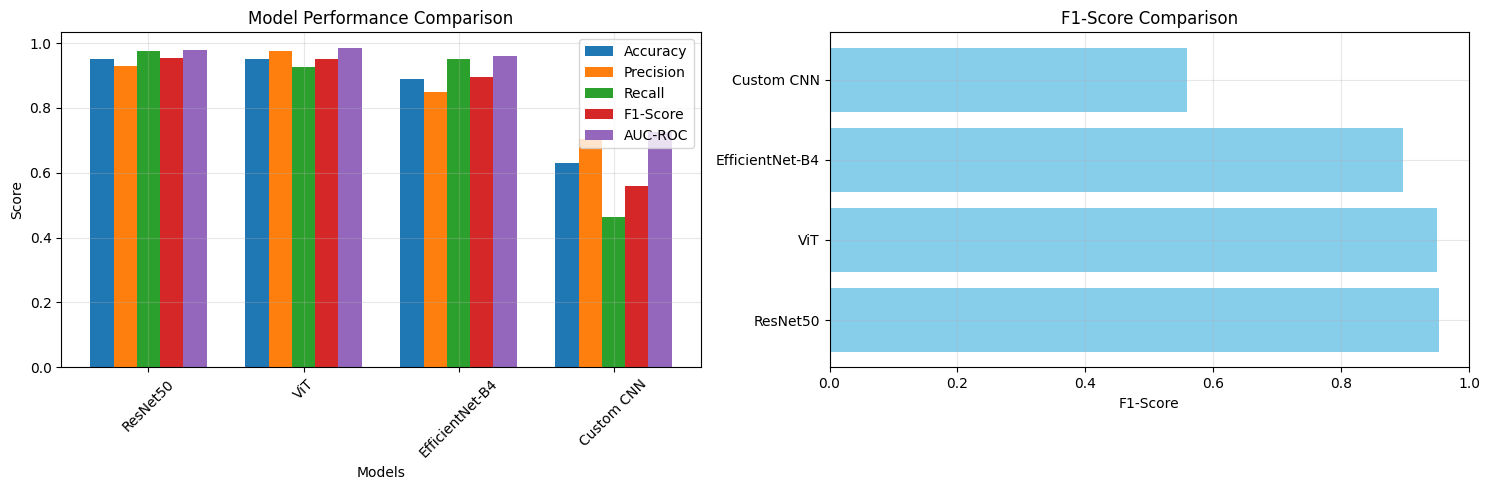


✅ Results visualization saved to results/model_comparison.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# results dataframe
results_df = pd.DataFrame({
    'Model': ['ResNet50', 'ViT', 'EfficientNet-B4', 'Custom CNN'],
    'Accuracy': [results['resnet50']['accuracy'], results['vit']['accuracy'],
                 results['efficientnet']['accuracy'], results['custom_cnn']['accuracy']],
    'Precision': [results['resnet50']['precision'], results['vit']['precision'],
                  results['efficientnet']['precision'], results['custom_cnn']['precision']],
    'Recall': [results['resnet50']['recall'], results['vit']['recall'],
               results['efficientnet']['recall'], results['custom_cnn']['recall']],
    'F1-Score': [results['resnet50']['f1'], results['vit']['f1'],
                 results['efficientnet']['f1'], results['custom_cnn']['f1']],
    'AUC-ROC': [results['resnet50']['auc_roc'], results['vit']['auc_roc'],
                results['efficientnet']['auc_roc'], results['custom_cnn']['auc_roc']]
})

print("\n" + "="*80)
print("FINAL RESULTS COMPARISON")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: All metrics
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
x = range(len(results_df))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    axes[0].bar([p + width*i for p in x], results_df[metric], width, label=metric)

axes[0].set_xlabel('Models')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks([p + width*2 for p in x])
axes[0].set_xticklabels(results_df['Model'], rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: F1-Score comparison
axes[1].barh(results_df['Model'], results_df['F1-Score'], color='skyblue')
axes[1].set_xlabel('F1-Score')
axes[1].set_title('F1-Score Comparison')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Results visualization saved to results/model_comparison.png")

## Step 14: Save Results

In [ ]:
import json

results_to_save = {
    model_name: {
        k: float(v) if not isinstance(v, (list, dict)) else v
        for k, v in metrics.items()
        if k != 'confusion_matrix'
    }
    for model_name, metrics in results.items()
}

with open('results/evaluation_results.json', 'w') as f:
    json.dump(results_to_save, f, indent=2)

print(" Results saved to results/evaluation_results.json")
print(" All checkpoints saved to checkpoints/")
print(" All visualizations saved to results/")

print("\n" + "="*80)
print(" TRAINING AND EVALUATION COMPLETE!")
print("="*80)
print("\nBest performing model:", results_df.loc[results_df['F1-Score'].idxmax(), 'Model'])
print(f"Best F1-Score: {results_df['F1-Score'].max():.4f}")

✅ Results saved to results/evaluation_results.json
✅ All checkpoints saved to checkpoints/
✅ All visualizations saved to results/

🎉 TRAINING AND EVALUATION COMPLETE!

Best performing model: ResNet50
Best F1-Score: 0.9524
